# Gesture Recognition

**Problem Statement:** Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
1. Thumbs up: Increase the volume 👍🔊
1. Thumbs down: Decrease the volume 👎🔉
1. Left swipe: 'Jump' backward 10 seconds ⬅️⏪
1. Right swipe: 'Jump' forward 10 seconds ➡️⏩
1. Stop: Pause the movie 🤚⏸️

The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 

# Imports

In [60]:
import numpy as np
import os
import imageio
import datetime
import matplotlib.pyplot as plt 
from PIL import Image
from abc import ABC, abstractmethod
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import cv2

np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

# Base Class

In [61]:
class GestureRecognitionModel:
    
    def __init__(self, batch_size=30, num_epochs=10, image_height=100, image_width=100, frames_to_sample=30,
                percent_of_training_sample = 1):
        
        self.train_path = '/kaggle/input/gesturerecognitionupgrad/Project_data/train'
        self.val_path = '/kaggle/input/gesturerecognitionupgrad/Project_data/val'
        train_doc_all = np.random.permutation(open('/kaggle/input/gesturerecognitionupgrad/Project_data/train.csv').readlines())
        self.train_doc = train_doc_all[:round(len(train_doc_all)*percent_of_training_sample)]
        self.val_doc = np.random.permutation(open('/kaggle/input/gesturerecognitionupgrad/Project_data/val.csv').readlines())
        
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.image_height = image_height
        self.image_width = image_width
        
        
        self.total_frames = 30
        self.frames_to_sample = frames_to_sample
        self.channels = 3
        self.num_classes = 5

    def train_model(self, model, augmentation=False, patience = 2, early_stop = True):
        train_generator = self.custom_generator(self.train_path, self.train_doc, self.batch_size, augmentation)
        val_generator = self.custom_generator(self.val_path, self.val_doc, self.batch_size)

        curr_dt_time = datetime.datetime.now()
        num_train_sequences = len(self.train_doc)
        num_val_sequences = len(self.val_doc)

        # Modify the filepath to save based on training loss
        model_name = 'Model' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

        if not os.path.exists('/kaggle/working/' + model_name):
            os.mkdir('/kaggle/working/' + model_name)

        filepath = '/kaggle/working/' + model_name + 'model-{epoch:05d}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.tf'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=patience, mode="auto", min_delta=1e-04, cooldown=0, min_lr=0.0001, verbose=1)
        early_stop_ob = EarlyStopping( monitor="val_loss", restore_best_weights=True, min_delta=0, patience=10,verbose=1)
        if early_stop:
            callbacks_list = [checkpoint, LR, early_stop_ob]
        else:
            callbacks_list = [checkpoint, LR]
        
        if (num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(num_train_sequences / self.batch_size)
        else:
            steps_per_epoch = (num_train_sequences // self.batch_size) + 1
        if (num_val_sequences % self.batch_size) == 0:
            validation_steps = int(num_val_sequences / self.batch_size)
        else:
            validation_steps = (num_val_sequences // self.batch_size) + 1

        trained_model = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                                  callbacks=callbacks_list, validation_data=val_generator,
                                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

        return trained_model
    
    def custom_generator(self, source_path, folder_list, batch_size, augmentation=False):
        img_idx = np.round(np.linspace(0, self.total_frames - 1, self.frames_to_sample)).astype(int)

        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(folder_list) // self.batch_size

            for batch in range(num_batches):
                batch_data = np.zeros((self.batch_size, len(img_idx), self.image_height, self.image_width, self.channels))
                batch_labels = np.zeros((self.batch_size, self.num_classes))

                if augmentation:
                    batch_data_augment = np.zeros((self.batch_size, len(img_idx), self.image_height, self.image_width, self.channels))

                for folder in range(batch_size):
                    imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                    for idx, item in enumerate(img_idx):
                        image_path = source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]
                        image = Image.open(image_path)
                        
                        image_resized = image.resize((self.image_height, self.image_width))

                        batch_data[folder, idx, :, :, 0] = np.array(image_resized)[:, :, 0] / 255.0
                        batch_data[folder, idx, :, :, 1] = np.array(image_resized)[:, :, 1] / 255.0
                        batch_data[folder, idx, :, :, 2] = np.array(image_resized)[:, :, 2] / 255.0

                        if augmentation:
                            image_np = np.array(image)
                            affine = cv2.warpAffine(image_np, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), (image_np.shape[1], image_np.shape[0]))
                    
                            gray_image = cv2.cvtColor(affine,cv2.COLOR_BGR2GRAY)

                            x0, y0 = np.argwhere(gray_image > 0).min(axis=0)
                            x1, y1 = np.argwhere(gray_image > 0).max(axis=0) 

                            cropped_image = affine[x0:x1,y0:y1,:]

                            resized_image = cv2.resize(cropped_image, (self.image_width, self.image_height))
                            
                            M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2), np.random.randint(-10,10), 1.0)
                            rotated = cv2.warpAffine(resized_image, M, (self.image_width, self.image_height))
                            
                            batch_data_augment[folder,idx,:,:,0] = (rotated[:,:,0])/255.0
                            batch_data_augment[folder,idx,:,:,1] = (rotated[:,:,1])/255.0
                            batch_data_augment[folder,idx,:,:,2] = (rotated[:,:,2])/255.0
                    
                    batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

                if augmentation:
                    batch_data = np.concatenate([batch_data, batch_data_augment])
                    batch_labels = np.concatenate([batch_labels, batch_labels])

                yield batch_data, batch_labels

            remaining_batch_size = len(folder_list) % batch_size
            if remaining_batch_size > 0:
                batch_data = np.zeros((remaining_batch_size, len(img_idx), self.image_height, self.image_width, self.channels))
                batch_labels = np.zeros((remaining_batch_size, self.num_classes))

                if augmentation:
                    batch_data_augment = np.zeros(
                        (remaining_batch_size, len(img_idx), self.image_height, self.image_width, self.channels))

                for folder in range(remaining_batch_size):
                    imgs = os.listdir(source_path + '/' + t[folder + (num_batches * batch_size)].split(';')[0])
                    for idx, item in enumerate(img_idx):
                        image_path = source_path + '/' + t[folder + (num_batches * batch_size)].strip().split(';')[0] + '/' + imgs[item]
                        
                        image = Image.open(image_path)
                        image_resized = image.resize((self.image_height, self.image_width))

                        batch_data[folder, idx, :, :, 0] = np.array(image_resized)[:, :, 0] / 255.0
                        batch_data[folder, idx, :, :, 1] = np.array(image_resized)[:, :, 1] / 255.0
                        batch_data[folder, idx, :, :, 2] = np.array(image_resized)[:, :, 2] / 255.0

                        if augmentation:
                            image_np = np.array(image)
                            affine = cv2.warpAffine(image_np, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), (image_np.shape[1], image_np.shape[0]))
                    
                            gray_image = cv2.cvtColor(affine,cv2.COLOR_BGR2GRAY)

                            x0, y0 = np.argwhere(gray_image > 0).min(axis=0)
                            x1, y1 = np.argwhere(gray_image > 0).max(axis=0) 
                            
                            # cropping the images to have the targeted gestures and remove the noise from the images.
                            
                            cropped_image = affine[x0:x1,y0:y1,:]

                            resized_image = cv2.resize(cropped_image, (self.image_width, self.image_height))
                            
                            M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2), np.random.randint(-10,10), 1.0)
                            rotated = cv2.warpAffine(resized_image, M, (self.image_width, self.image_height))
                            
                            batch_data_augment[folder,idx,:,:,0] = (rotated[:,:,0])/255.0
                            batch_data_augment[folder,idx,:,:,1] = (rotated[:,:,1])/255.0
                            batch_data_augment[folder,idx,:,:,2] = (rotated[:,:,2])/255.0
                        
                    batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

                if augmentation:
                    batch_data = np.concatenate([batch_data, batch_data_augment])
                    batch_labels = np.concatenate([batch_labels, batch_labels])

                yield batch_data, batch_labels
    
    @abstractmethod
    def build_model(self):
        pass

In [62]:
def plot_training_history(training_history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

    # Plotting Loss
    axes[0].plot(training_history.history['loss'], label='Training Loss')
    axes[0].plot(training_history.history['val_loss'], label='Validation Loss')
    axes[0].grid()
    axes[0].legend()
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')

    # Plotting Accuracy
    axes[1].plot(training_history.history['categorical_accuracy'], label='Training Accuracy')
    axes[1].plot(training_history.history['val_categorical_accuracy'], label='Validation Accuracy')
    axes[1].grid()
    axes[1].legend()
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')

    plt.show()

# Model 1
 ### Basic model with 3 layers and 1 fully connected layer

In [ ]:
class Model1(GestureRecognitionModel):
    
    def build_model(self):
        model = Sequential()

        # Convolutional Layers
        filters_list = [8, 32, 64]
        model.add(Conv3D(filters_list[0], kernel_size=(3, 3, 3), padding='same', 
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        for filters in filters_list[1:]:
            model.add(Conv3D(filters, kernel_size=(3, 3, 3), padding='same'))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Flatten layer
        model.add(Flatten())
        
        # Fully Connected Layers
        model.add(Dense(32, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compiling the model
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model


In [5]:
frames_to_sample = 30
batch_size = 30
num_epochs = 2
training_sample = 0.5
image_height = 160
image_width = 160
test_model = Model1(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample, 
                       num_epochs = num_epochs, image_height=image_height, image_width = image_width)
test_model1 = test_model.build_model()
print(test_model1.summary())

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d (Conv3D)             (None, 30, 160, 160, 8)   656       

                                                                 

 batch_normalization (Batch  (None, 30, 160, 160, 8)   32        

 Normalization)                                                  

                                                                 

 activation (Activation)     (None, 30, 160, 160, 8)   0         

                                                                 

 max_pooling3d (MaxPooling3  (None, 15, 80, 80, 8)     0         

 D)                                                              

                                                                 

 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    6944      

                                                                 

 batch_normalization_1 (Bat  (None, 15, 

# Testing all the functions

### Generator

In [6]:
gen = test_model.custom_generator(test_model.val_path, test_model.val_doc, test_model.batch_size)
batch_data, batch_labels=next(gen)
print(batch_data.shape)
print(len(batch_labels))

(30, 30, 160, 160, 3)

30


### Plotting  images processed via generator

In [7]:
def plot_images(batch_data, batch_labels, axes):
    row, col = 0, 0
    for y in range(frames_to_sample):
        if y % num_cols == 0 and y != 0:
            col = 0
            row += 1
        axes[row][col].imshow(batch_data[x, y, :, :, :])
        axes[row][col].axis('off')  # Remove x and y axes
        col += 1
        
num_rows = (frames_to_sample + 4) // 5  
num_cols = min(frames_to_sample, 5)  

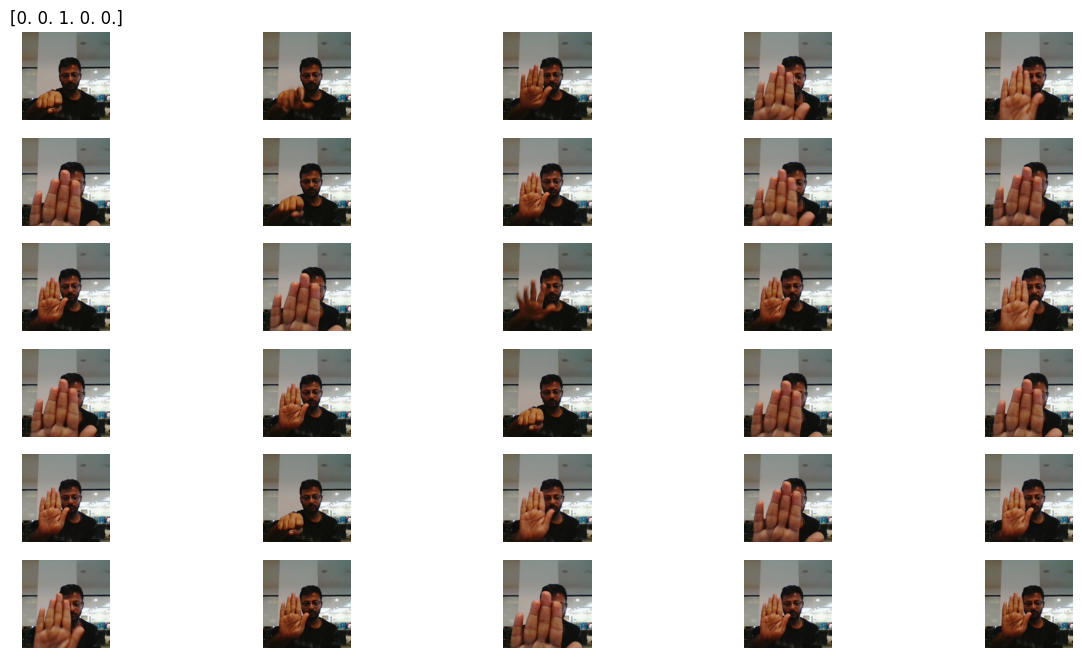

In [8]:
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 8))

imagenumber = 6
for x in range(imagenumber, batch_data.shape[0]):
    plot_images(batch_data, batch_labels, axes)
    axes[0][0].set_title(label=batch_labels[x], fontsize=12)
    break

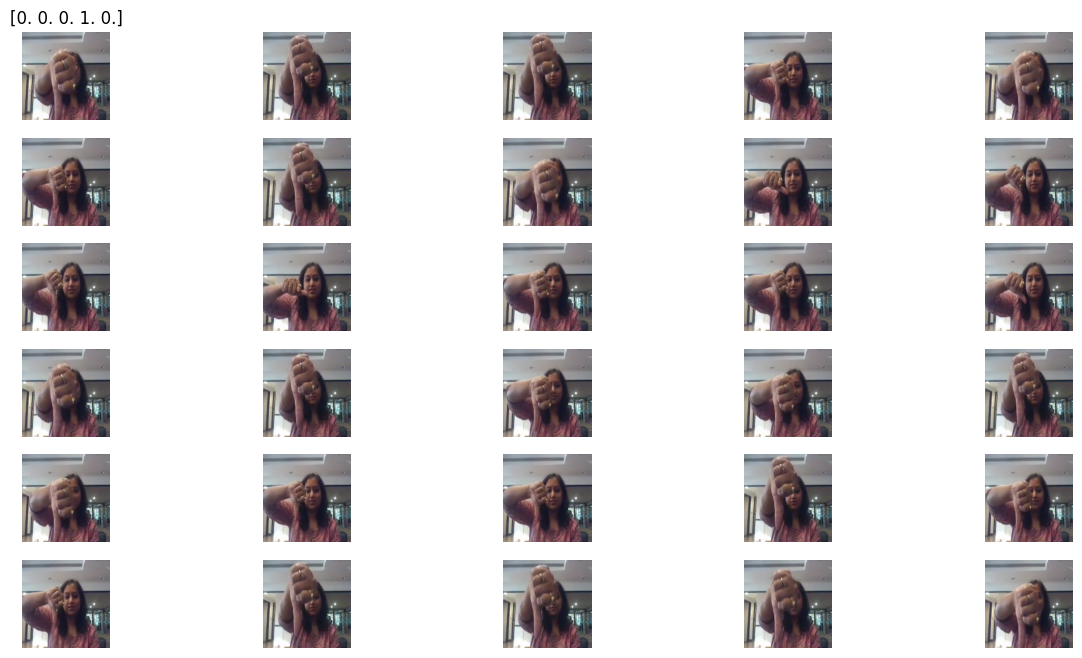

In [9]:
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 8))

imagenumber = 8
for x in range(imagenumber, batch_data.shape[0]):
    plot_images(batch_data, batch_labels, axes)
    axes[0][0].set_title(label=batch_labels[x], fontsize=12)
    break

### Testing train function and Experimenting with batch_size, image resolution, frames_to_sample

In [10]:
# frames_to_sample = 30
# batch_size = 30
# num_epochs = 2
# training_sample = 0.5
# image_height = 160
# image_width = 160
experiment_model1 = test_model.train_model(test_model1)

Epoch 1/2

12/12 [==============================] - ETA: 0s - loss: 2.3709 - categorical_accuracy: 0.3825

Epoch 1: val_loss improved from inf to 2.95955, saving model to /kaggle/working/Model_2023-12-0806_32_19.402207/model-00001-2.95955-0.22000.tf

12/12 [==============================] - 143s 12s/step - loss: 2.3709 - categorical_accuracy: 0.3825 - val_loss: 2.9595 - val_categorical_accuracy: 0.2200 - lr: 0.0010

Epoch 2/2

12/12 [==============================] - ETA: 0s - loss: 2.1528 - categorical_accuracy: 0.5904

Epoch 2: val_loss improved from 2.95955 to 2.73595, saving model to /kaggle/working/Model_2023-12-0806_32_19.402207/model-00002-2.73595-0.30000.tf

12/12 [==============================] - 61s 5s/step - loss: 2.1528 - categorical_accuracy: 0.5904 - val_loss: 2.7359 - val_categorical_accuracy: 0.3000 - lr: 0.0010


In [13]:
frames_to_sample = 30
batch_size = 30
num_epochs = 2
training_sample = 1
image_height=140
image_width=140
test_model = Model1(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height=image_height, image_width=image_width)
test_model2 = test_model.build_model()
print(test_model2.summary())

Model: "sequential_2"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_6 (Conv3D)           (None, 30, 140, 140, 8)   656       

                                                                 

 batch_normalization_8 (Bat  (None, 30, 140, 140, 8)   32        

 chNormalization)                                                

                                                                 

 activation_6 (Activation)   (None, 30, 140, 140, 8)   0         

                                                                 

 max_pooling3d_6 (MaxPoolin  (None, 15, 70, 70, 8)     0         

 g3D)                                                            

                                                                 

 conv3d_7 (Conv3D)           (None, 15, 70, 70, 32)    6944      

                                                                 

 batch_normalization_9 (Bat  (None, 15

In [14]:
experiment_model2 = test_model.train_model(test_model2)

Epoch 1/2

23/23 [==============================] - ETA: 0s - loss: 2.3073 - categorical_accuracy: 0.4118

Epoch 1: val_loss improved from inf to 2.55549, saving model to /kaggle/working/Model_2023-12-0806_37_51.575120/model-00001-2.55549-0.33000.tf

23/23 [==============================] - 172s 7s/step - loss: 2.3073 - categorical_accuracy: 0.4118 - val_loss: 2.5555 - val_categorical_accuracy: 0.3300 - lr: 0.0010

Epoch 2/2

23/23 [==============================] - ETA: 0s - loss: 2.0376 - categorical_accuracy: 0.5520

Epoch 2: val_loss did not improve from 2.55549

23/23 [==============================] - 101s 5s/step - loss: 2.0376 - categorical_accuracy: 0.5520 - val_loss: 3.1774 - val_categorical_accuracy: 0.2000 - lr: 0.0010


In [17]:
frames_to_sample = 20
batch_size = 50
num_epochs = 2
training_sample = 1
image_height = 120
image_width = 120
test_model = Model1(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height=image_height, image_width = image_width)
test_model3 = test_model.build_model()
print(test_model3.count_params())

985301


In [16]:
experiment_model3 = test_model.train_model(test_model3)

Epoch 1/2

14/14 [==============================] - ETA: 0s - loss: 2.3087 - categorical_accuracy: 0.3861

Epoch 1: val_loss improved from inf to 2.68553, saving model to /kaggle/working/Model_2023-12-0806_47_02.963605/model-00001-2.68553-0.19000.tf

14/14 [==============================] - 76s 5s/step - loss: 2.3087 - categorical_accuracy: 0.3861 - val_loss: 2.6855 - val_categorical_accuracy: 0.1900 - lr: 0.0010

Epoch 2/2

14/14 [==============================] - ETA: 0s - loss: 1.9345 - categorical_accuracy: 0.5475

Epoch 2: val_loss did not improve from 2.68553

14/14 [==============================] - 58s 4s/step - loss: 1.9345 - categorical_accuracy: 0.5475 - val_loss: 2.6862 - val_categorical_accuracy: 0.1500 - lr: 0.0010


### Number of frames to sample from each video and image resolution affect the size of model directly.
### Starting with 140*140 resolution, all the frames, 15 epochs and all the training samples.

In [19]:
frames_to_sample = 30
batch_size = 50
num_epochs = 15
training_sample = 1
image_height = 140
image_width = 140
test_model = Model1(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height=image_height, image_width = image_width)
test_model4 = test_model.build_model()
print(test_model4.count_params())

1839317


In [20]:
experiment_model4 = test_model.train_model(test_model4)

Epoch 1/15

14/14 [==============================] - ETA: 0s - loss: 2.6402 - categorical_accuracy: 0.3303

Epoch 1: val_loss improved from inf to 2.84152, saving model to /kaggle/working/Model_2023-12-0807_09_43.334825/model-00001-2.84152-0.18000.tf

14/14 [==============================] - 129s 9s/step - loss: 2.6402 - categorical_accuracy: 0.3303 - val_loss: 2.8415 - val_categorical_accuracy: 0.1800 - lr: 0.0010

Epoch 2/15

14/14 [==============================] - ETA: 0s - loss: 2.1487 - categorical_accuracy: 0.5415

Epoch 2: val_loss did not improve from 2.84152

14/14 [==============================] - 98s 7s/step - loss: 2.1487 - categorical_accuracy: 0.5415 - val_loss: 3.2895 - val_categorical_accuracy: 0.1900 - lr: 0.0010

Epoch 3/15

14/14 [==============================] - ETA: 0s - loss: 1.9515 - categorical_accuracy: 0.6606

Epoch 3: val_loss did not improve from 2.84152



Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

14/14 [===============

#### The model is learning properly but overfitting on the train set.

### Adding Augmentations to overcome overfitting

In [35]:
frames_to_sample = 20
batch_size = 50
num_epochs = 15
training_sample = 1
image_height = 140
image_width = 140
model1 = Model1(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height=image_height, image_width = image_width)
model1_1 = model1.build_model()
print(model1_1.count_params())

1247445


### Plotting Augmentations

In [36]:
gen = model1.custom_generator(model1.train_path, model1.train_doc, model1.batch_size, augmentation=True)
batch_data, batch_labels=next(gen)
print(batch_data.shape)
print(len(batch_labels))

(100, 20, 140, 140, 3)

100


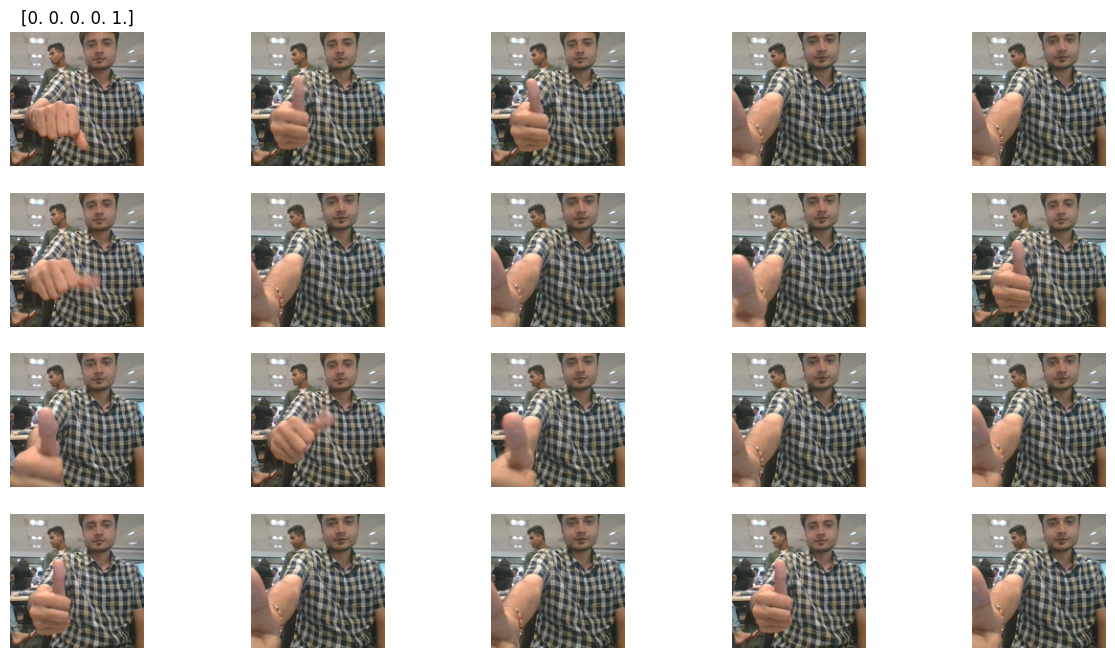

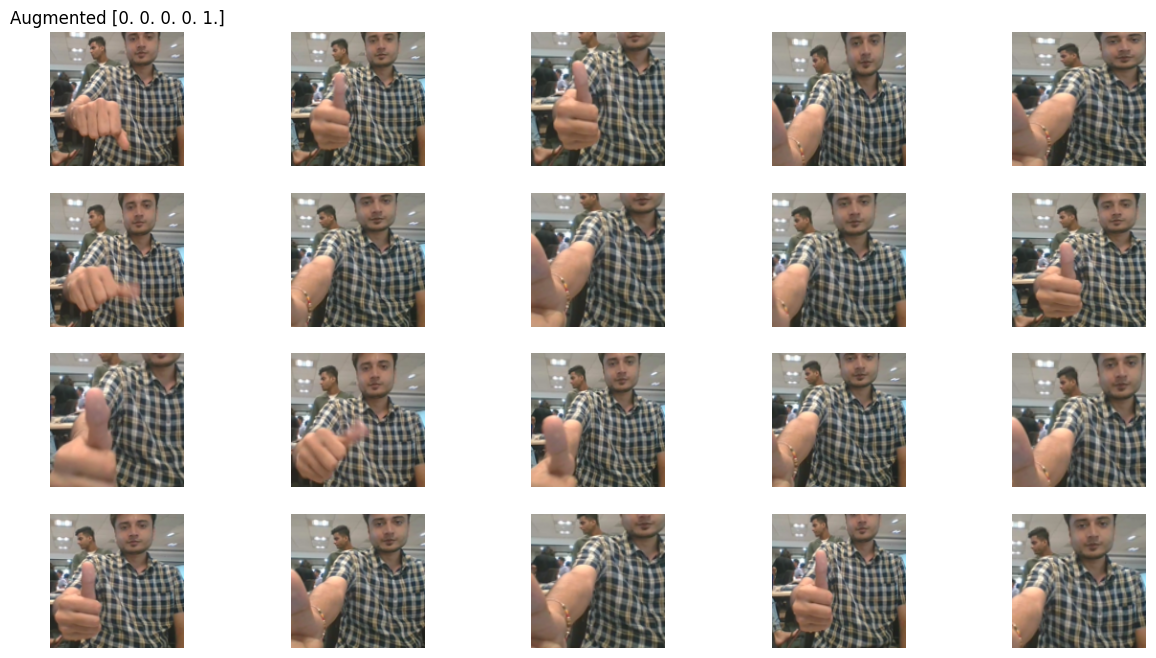

In [27]:
def plot_images(batch_data, batch_labels, axes):
    row, col = 0, 0
    for y in range(frames_to_sample):
        if y % num_cols == 0 and y != 0:
            col = 0
            row += 1
        axes[row][col].imshow(batch_data[x, y, :, :, :])
        axes[row][col].axis('off')  # Remove x and y axes
        col += 1

num_rows = (frames_to_sample + 4) // 5  
num_cols = min(frames_to_sample, 5)  

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 8))

imagenumber = 6 
for x in range(imagenumber, batch_data.shape[0]):
    plot_images(batch_data, batch_labels, axes)
    axes[0][0].set_title(label=batch_labels[x], fontsize=12)
    break

imagenumber += batch_size
fig1, axes2 = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 8))

for x in range(imagenumber, batch_data.shape[0]):
    plot_images(batch_data, batch_labels, axes2)
    axes2[0][0].set_title(label='Augmented '+str(batch_labels[x]), fontsize=12)
    break

plt.show()

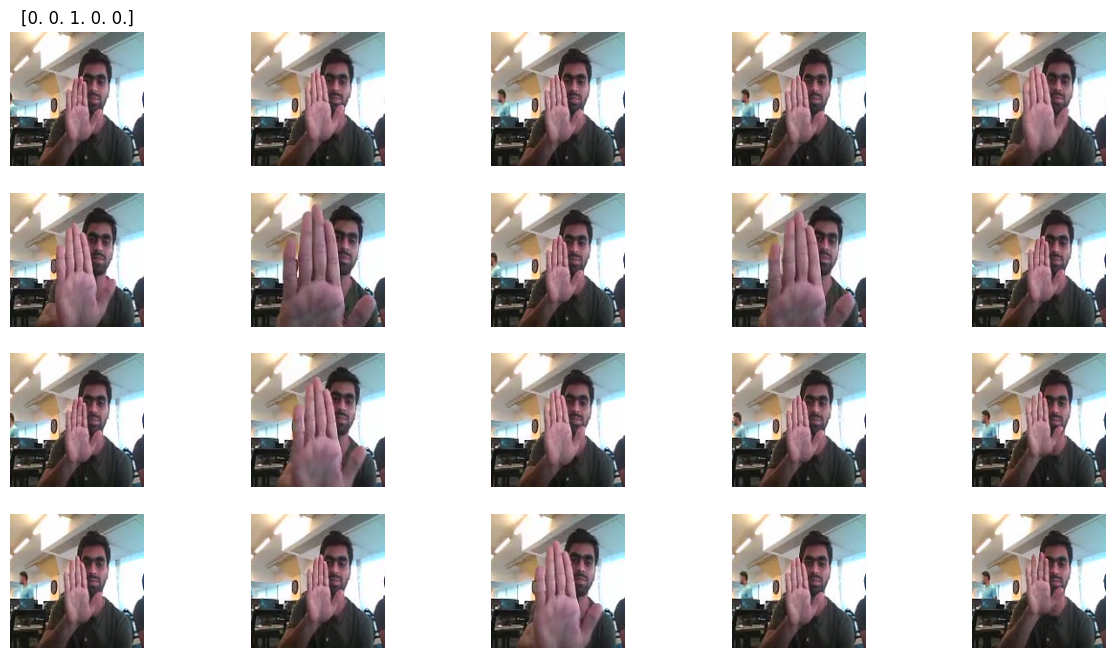

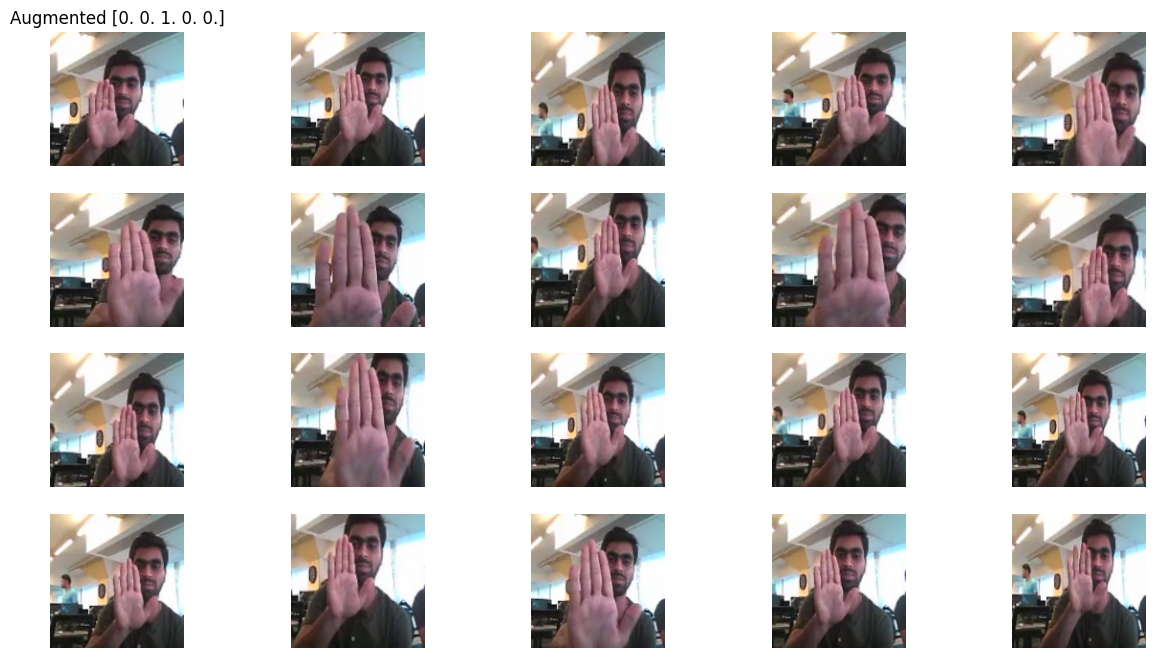

In [37]:
num_rows = (frames_to_sample + 4) // 5  
num_cols = min(frames_to_sample, 5)  

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 8))

imagenumber = 9 
for x in range(imagenumber, batch_data.shape[0]):
    plot_images(batch_data, batch_labels, axes)
    axes[0][0].set_title(label=batch_labels[x], fontsize=12)
    break

imagenumber += batch_size
fig1, axes2 = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 8))

for x in range(imagenumber, batch_data.shape[0]):
    plot_images(batch_data, batch_labels, axes2)
    axes2[0][0].set_title(label='Augmented '+str(batch_labels[x]), fontsize=12)
    break

plt.show()

In [38]:
trained_model_1 = model1.train_model(model1_1, augmentation = True)

Epoch 1/15

14/14 [==============================] - ETA: 0s - loss: 2.3215 - categorical_accuracy: 0.4042

Epoch 1: val_loss improved from inf to 2.38679, saving model to /kaggle/working/Model_2023-12-0807_44_36.546424/model-00001-2.38679-0.23000.tf

14/14 [==============================] - 106s 7s/step - loss: 2.3215 - categorical_accuracy: 0.4042 - val_loss: 2.3868 - val_categorical_accuracy: 0.2300 - lr: 0.0010

Epoch 2/15

14/14 [==============================] - ETA: 0s - loss: 1.9492 - categorical_accuracy: 0.5400

Epoch 2: val_loss did not improve from 2.38679

14/14 [==============================] - 89s 7s/step - loss: 1.9492 - categorical_accuracy: 0.5400 - val_loss: 2.7144 - val_categorical_accuracy: 0.2500 - lr: 0.0010

Epoch 3/15

14/14 [==============================] - ETA: 0s - loss: 1.7777 - categorical_accuracy: 0.6320

Epoch 3: val_loss did not improve from 2.38679



Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

14/14 [===============

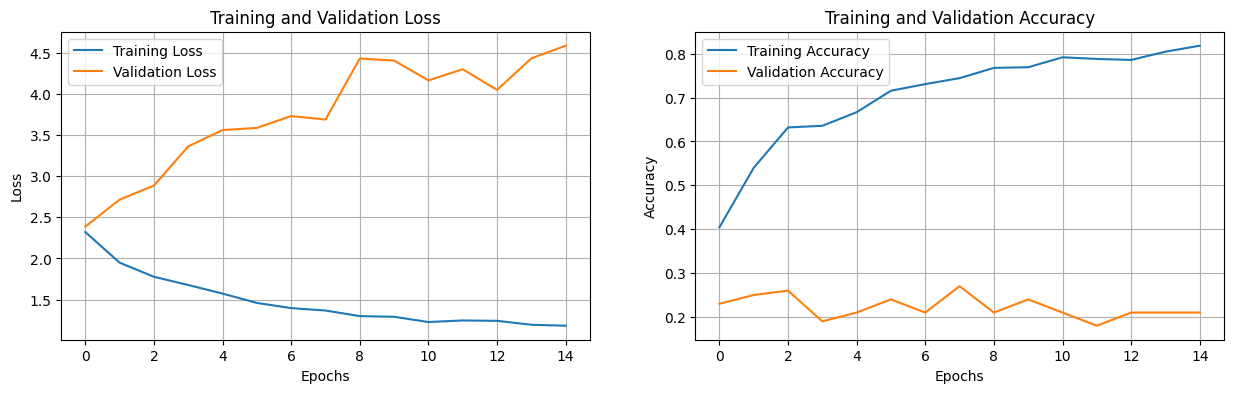

In [39]:
plot_training_history(trained_model_1)

# Model 2
### Added L2 regularization, increased dense layer filter to 64, LR plateau from 2 to 5, epoch to 20 and reduced image resolution to 120*120

In [ ]:
class Model2(GestureRecognitionModel):
    
    def build_model(self):
        model = Sequential()

        # Convolutional Layers
        filters_list = [8, 32, 64]
        
        model.add(Conv3D(filters_list[0], kernel_size=(3, 3, 3), padding='same', 
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels), kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        for filters in filters_list[1:]:
            model.add(Conv3D(filters, kernel_size=(3, 3, 3), padding='same', kernel_regularizer=l2(0.01)))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Flatten layer
        model.add(Flatten())
        
        # Fully Connected Layers
        model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compiling the model
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model


In [46]:
frames_to_sample = 20
batch_size = 50
num_epochs = 20
training_sample = 1
image_height = 120
image_width = 120
con3d_model2 = Model2(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height=image_height, image_width = image_width)
model2_1 = con3d_model2.build_model()
print(model2_1.summary())

Model: "sequential_13"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_39 (Conv3D)          (None, 20, 120, 120, 8)   656       

                                                                 

 batch_normalization_51 (Ba  (None, 20, 120, 120, 8)   32        

 tchNormalization)                                               

                                                                 

 activation_39 (Activation)  (None, 20, 120, 120, 8)   0         

                                                                 

 max_pooling3d_39 (MaxPooli  (None, 10, 60, 60, 8)     0         

 ng3D)                                                           

                                                                 

 conv3d_40 (Conv3D)          (None, 10, 60, 60, 32)    6944      

                                                                 

 batch_normalization_52 (Ba  (None, 1

In [47]:
trained_model_2 = con3d_model2.train_model(model2_1, augmentation = True, patience=5)

Epoch 1/20

14/14 [==============================] - ETA: 0s - loss: 3.5029 - categorical_accuracy: 0.4525

Epoch 1: val_loss improved from inf to 3.88524, saving model to /kaggle/working/Model_2023-12-0808_14_42.319850/model-00001-3.88524-0.18000.tf

14/14 [==============================] - 92s 6s/step - loss: 3.5029 - categorical_accuracy: 0.4525 - val_loss: 3.8852 - val_categorical_accuracy: 0.1800 - lr: 0.0010

Epoch 2/20

14/14 [==============================] - ETA: 0s - loss: 3.2280 - categorical_accuracy: 0.5551

Epoch 2: val_loss did not improve from 3.88524

14/14 [==============================] - 75s 6s/step - loss: 3.2280 - categorical_accuracy: 0.5551 - val_loss: 4.6589 - val_categorical_accuracy: 0.3000 - lr: 0.0010

Epoch 3/20

14/14 [==============================] - ETA: 0s - loss: 2.9043 - categorical_accuracy: 0.6192

Epoch 3: val_loss did not improve from 3.88524

14/14 [==============================] - 75s 6s/step - loss: 2.9043 - categorical_accuracy: 0.6192 - v

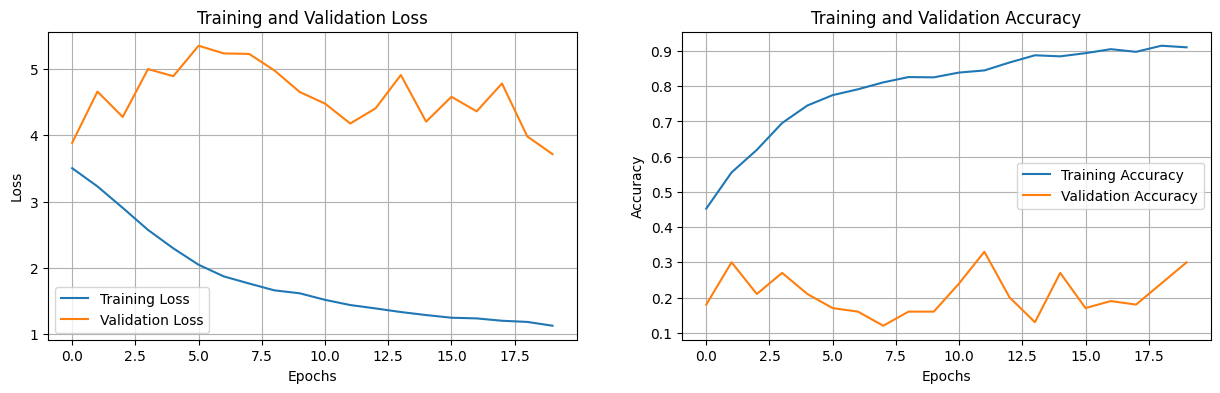

In [48]:
plot_training_history(trained_model_2)

In [51]:
frames_to_sample = 30
batch_size = 50
num_epochs = 30
training_sample = 1
image_height = 120
image_width = 120
con3d_model2 = Model2(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height=image_height, image_width = image_width)
model2_2 = con3d_model2.build_model()
print(model2_2.summary())

Model: "sequential_16"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_48 (Conv3D)          (None, 30, 120, 120, 8)   656       

                                                                 

 batch_normalization_63 (Ba  (None, 30, 120, 120, 8)   32        

 tchNormalization)                                               

                                                                 

 activation_48 (Activation)  (None, 30, 120, 120, 8)   0         

                                                                 

 max_pooling3d_48 (MaxPooli  (None, 15, 60, 60, 8)     0         

 ng3D)                                                           

                                                                 

 conv3d_49 (Conv3D)          (None, 15, 60, 60, 32)    6944      

                                                                 

 batch_normalization_64 (Ba  (None, 1

In [54]:
trained_model_3 = con3d_model2.train_model(model2_2, augmentation = True, patience=3)

Epoch 1/30

14/14 [==============================] - ETA: 0s - loss: 3.5654 - categorical_accuracy: 0.3952 

Epoch 1: val_loss improved from inf to 4.01838, saving model to /kaggle/working/Model_2023-12-0808_55_45.694035/model-00001-4.01838-0.18000.tf

14/14 [==============================] - 187s 14s/step - loss: 3.5654 - categorical_accuracy: 0.3952 - val_loss: 4.0184 - val_categorical_accuracy: 0.1800 - lr: 0.0010

Epoch 2/30

14/14 [==============================] - ETA: 0s - loss: 3.2485 - categorical_accuracy: 0.5641 

Epoch 2: val_loss did not improve from 4.01838

14/14 [==============================] - 170s 13s/step - loss: 3.2485 - categorical_accuracy: 0.5641 - val_loss: 4.1695 - val_categorical_accuracy: 0.2400 - lr: 0.0010

Epoch 3/30

14/14 [==============================] - ETA: 0s - loss: 2.9455 - categorical_accuracy: 0.6614

Epoch 3: val_loss did not improve from 4.01838

14/14 [==============================] - 118s 9s/step - loss: 2.9455 - categorical_accuracy: 0.6

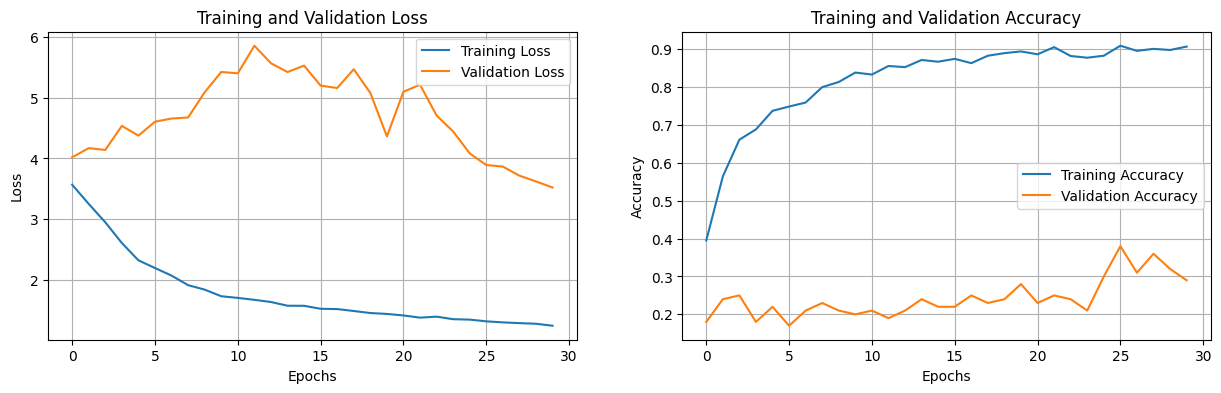

In [55]:
plot_training_history(trained_model_3)

# Model 3
### Reducing filters, frames to sample, epochs, batch size

In [ ]:
class Model3(GestureRecognitionModel):
    
    def build_model(self):
        model = Sequential()

        # Convolutional Layers
        filters_list = [8,16,32]
        
        model.add(Conv3D(filters_list[0], kernel_size=(3, 3, 3), padding='same', 
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels), kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        for filters in filters_list[1:]:
            model.add(Conv3D(filters, kernel_size=(3, 3, 3), padding='same', kernel_regularizer=l2(0.01)))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Flatten layer
        model.add(Flatten())
        
        # Fully Connected Layers
        model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compiling the model
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model

In [6]:
frames_to_sample = 25
batch_size = 45
num_epochs = 25
training_sample = 1
image_height = 120
image_width = 120
con3d_model3 = Model3(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height=image_height, image_width = image_width)
model3_1 = con3d_model3.build_model()
print(model3_1.summary())

Model: "sequential_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_3 (Conv3D)           (None, 25, 120, 120, 8)   656       

                                                                 

 batch_normalization_4 (Bat  (None, 25, 120, 120, 8)   32        

 chNormalization)                                                

                                                                 

 activation_3 (Activation)   (None, 25, 120, 120, 8)   0         

                                                                 

 max_pooling3d_3 (MaxPoolin  (None, 12, 60, 60, 8)     0         

 g3D)                                                            

                                                                 

 conv3d_4 (Conv3D)           (None, 12, 60, 60, 16)    3472      

                                                                 

 batch_normalization_5 (Bat  (None, 12

In [7]:
trained_model_4 = con3d_model3.train_model(model3_1, augmentation = True, patience=3)

Epoch 1/25

15/15 [==============================] - ETA: 0s - loss: 3.3565 - categorical_accuracy: 0.4148 

Epoch 1: val_loss improved from inf to 5.88249, saving model to /kaggle/working/Model_2023-12-0810_13_02.846452/model-00001-5.88249-0.18000.tf

15/15 [==============================] - 257s 17s/step - loss: 3.3565 - categorical_accuracy: 0.4148 - val_loss: 5.8825 - val_categorical_accuracy: 0.1800 - lr: 0.0010

Epoch 2/25

15/15 [==============================] - ETA: 0s - loss: 2.9045 - categorical_accuracy: 0.5649

Epoch 2: val_loss improved from 5.88249 to 3.28398, saving model to /kaggle/working/Model_2023-12-0810_13_02.846452/model-00002-3.28398-0.31000.tf

15/15 [==============================] - 107s 8s/step - loss: 2.9045 - categorical_accuracy: 0.5649 - val_loss: 3.2840 - val_categorical_accuracy: 0.3100 - lr: 0.0010

Epoch 3/25

15/15 [==============================] - ETA: 0s - loss: 2.5244 - categorical_accuracy: 0.6599

Epoch 3: val_loss did not improve from 3.28398

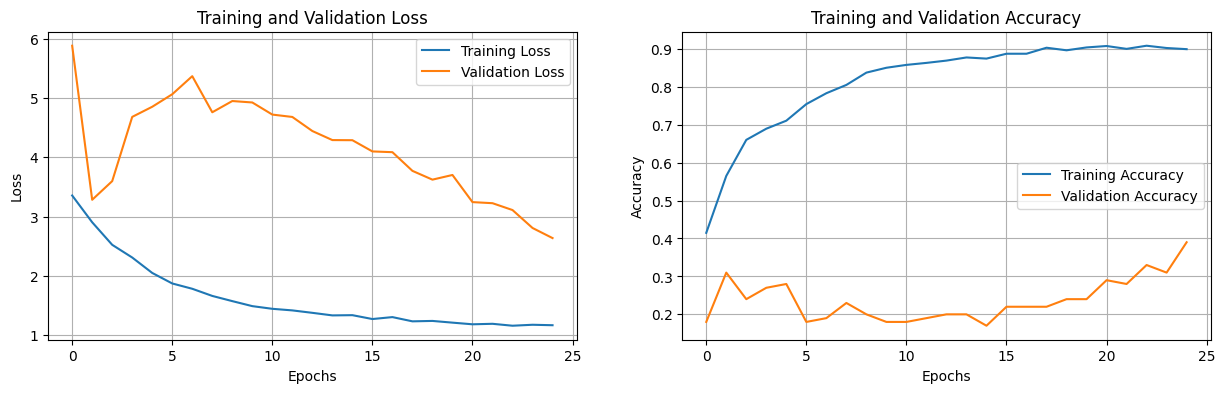

In [8]:
plot_training_history(trained_model_4)

### The accuracy is going up and the val loss is also decreasing, the model accuracy would have been better if we ran it for more epochs.

# Model 4
### 2 Con3D layers and 1 fully connected with dropout and regularization and running it for 30 epochs.

In [ ]:
class Model4(GestureRecognitionModel):
    
    def build_model(self):
        model = Sequential()

        # Convolutional Layers
        filters_list = [8, 16] 
        
        model.add(Conv3D(filters_list[0], kernel_size=(3, 3, 3), padding='same', 
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels), kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        for filters in filters_list[1:]:
            model.add(Conv3D(filters, kernel_size=(3, 3, 3), padding='same', kernel_regularizer=l2(0.01)))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Flatten layer
        model.add(Flatten())

        # Fully Connected Layers
        model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
            
        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile the model
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
        return model

In [15]:
frames_to_sample = 25
batch_size = 45
num_epochs = 30
training_sample = 1
image_height = 120
image_width = 120
con3d_model4 = Model4(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height=image_height, image_width = image_width)
model4_1 = con3d_model4.build_model()
print(model4_1.summary())

Model: "sequential_3"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_9 (Conv3D)           (None, 25, 120, 120, 8)   656       

                                                                 

 batch_normalization_13 (Ba  (None, 25, 120, 120, 8)   32        

 tchNormalization)                                               

                                                                 

 activation_9 (Activation)   (None, 25, 120, 120, 8)   0         

                                                                 

 max_pooling3d_9 (MaxPoolin  (None, 12, 60, 60, 8)     0         

 g3D)                                                            

                                                                 

 conv3d_10 (Conv3D)          (None, 12, 60, 60, 16)    3472      

                                                                 

 batch_normalization_14 (Ba  (None, 12

In [16]:
trained_model_5 = con3d_model4.train_model(model4_1, augmentation = True, patience=3)

Epoch 1/30

15/15 [==============================] - ETA: 0s - loss: 2.8734 - categorical_accuracy: 0.3235

Epoch 1: val_loss improved from inf to 2.90683, saving model to /kaggle/working/Model_2023-12-0811_04_17.615346/model-00001-2.90683-0.21000.tf

15/15 [==============================] - 121s 8s/step - loss: 2.8734 - categorical_accuracy: 0.3235 - val_loss: 2.9068 - val_categorical_accuracy: 0.2100 - lr: 0.0010

Epoch 2/30

15/15 [==============================] - ETA: 0s - loss: 2.7968 - categorical_accuracy: 0.4261

Epoch 2: val_loss did not improve from 2.90683

15/15 [==============================] - 102s 7s/step - loss: 2.7968 - categorical_accuracy: 0.4261 - val_loss: 3.0929 - val_categorical_accuracy: 0.2800 - lr: 0.0010

Epoch 3/30

15/15 [==============================] - ETA: 0s - loss: 2.5580 - categorical_accuracy: 0.4992

Epoch 3: val_loss did not improve from 2.90683

15/15 [==============================] - 97s 7s/step - loss: 2.5580 - categorical_accuracy: 0.4992 -

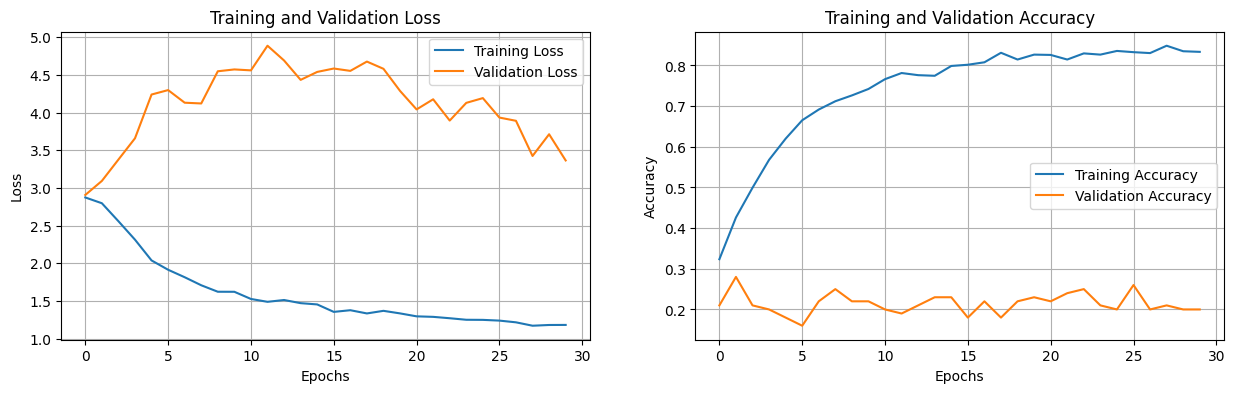

In [21]:
plot_training_history(trained_model_5)

### This model is poor in comparision to model 3, lets increase the number parameters try again.

# Model 5
### Changing number of filters and adding one more dense layer

In [ ]:
class Model5(GestureRecognitionModel):
    
    def build_model(self):
        model = Sequential()

        # Convolutional Layers
        filters_list = [8, 16, 32, 64]

        model.add(Conv3D(filters_list[0], kernel_size=(3, 3, 3), padding='same', 
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels), kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        for filters in filters_list[1:]:
            model.add(Conv3D(filters, kernel_size=(3, 3, 3), padding='same', kernel_regularizer=l2(0.01)))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        # Flatten layer
        model.add(Flatten())

        # Fully Connected Layers
        dense_units = [64, 32]
        for units in dense_units:
            model.add(Dense(units, activation='relu', kernel_regularizer=l2(0.01)))
            model.add(BatchNormalization())
            model.add(Dropout(0.25))
            
        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile the model
        optimiser = tf.keras.optimizers.Adam(lr=0.0001)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
        return model

In [51]:
frames_to_sample = 20
batch_size = 50
num_epochs = 30
training_sample = 1
image_height = 120
image_width = 120
con3d_model5 = Model5(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height=image_height, image_width = image_width)
model5_1 = con3d_model5.build_model()
print(model5_1.summary())

Model: "sequential_20"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_49 (Conv3D)          (None, 20, 120, 120, 8)   656       

                                                                 

 batch_normalization_86 (Ba  (None, 20, 120, 120, 8)   32        

 tchNormalization)                                               

                                                                 

 activation_49 (Activation)  (None, 20, 120, 120, 8)   0         

                                                                 

 max_pooling3d_49 (MaxPooli  (None, 10, 60, 60, 8)     0         

 ng3D)                                                           

                                                                 

 conv3d_50 (Conv3D)          (None, 10, 60, 60, 16)    3472      

                                                                 

 batch_normalization_87 (Ba  (None, 1

In [52]:
trained_model_6 = con3d_model5.train_model(model5_1, augmentation=True, patience = 3)

Epoch 1/30

14/14 [==============================] - ETA: 0s - loss: 4.2093 - categorical_accuracy: 0.3492

Epoch 1: val_loss improved from inf to 4.02165, saving model to /kaggle/working/Model_2023-12-0812_21_41.190108/model-00001-4.02165-0.36000.tf

14/14 [==============================] - 100s 7s/step - loss: 4.2093 - categorical_accuracy: 0.3492 - val_loss: 4.0216 - val_categorical_accuracy: 0.3600 - lr: 0.0010

Epoch 2/30

14/14 [==============================] - ETA: 0s - loss: 3.6468 - categorical_accuracy: 0.5038

Epoch 2: val_loss did not improve from 4.02165

14/14 [==============================] - 79s 6s/step - loss: 3.6468 - categorical_accuracy: 0.5038 - val_loss: 4.7282 - val_categorical_accuracy: 0.2400 - lr: 0.0010

Epoch 3/30

14/14 [==============================] - ETA: 0s - loss: 3.3869 - categorical_accuracy: 0.5716

Epoch 3: val_loss did not improve from 4.02165

14/14 [==============================] - 84s 6s/step - loss: 3.3869 - categorical_accuracy: 0.5716 - 

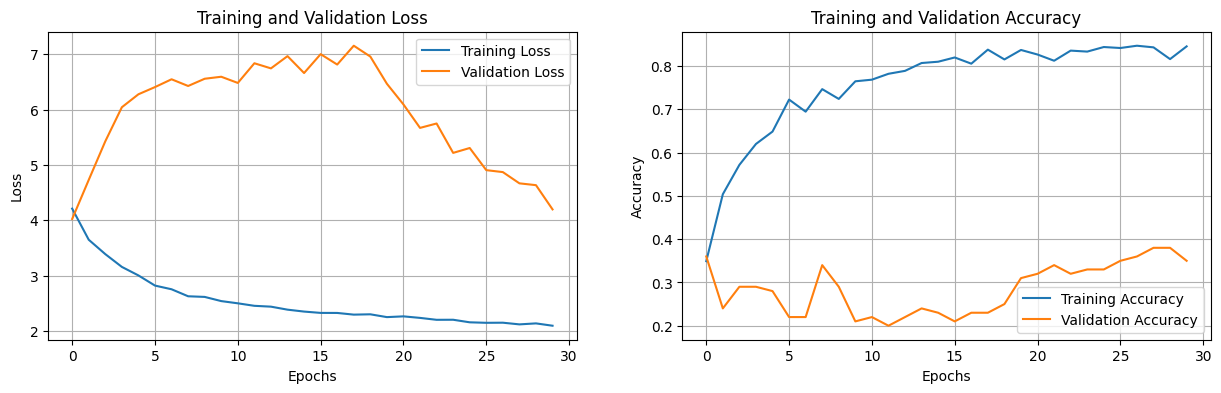

In [53]:
plot_training_history(trained_model_6)

### We can see the val loss dropping after the 17th epoch 

# Model 6
### reducing cnn layer with regularization , increasing learning rate

In [ ]:
class Model6(GestureRecognitionModel):
    
    def build_model(self):
        model = Sequential()

        # Convolutional Layers
        filters_list = [8, 32, 64]  # Reduced number of filters
        model.add(Conv3D(filters_list[0], kernel_size=(3, 3, 3), padding='same', 
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels), kernel_regularizer=l2(0.03)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        for filters in filters_list[1:]:
            model.add(Conv3D(filters, kernel_size=(3, 3, 3), padding='same', kernel_regularizer=l2(0.03)))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Flatten layer
        model.add(Flatten())

        # Fully Connected Layers
        dense_units = [64, 32] 
        for units in dense_units:
            model.add(Dense(units, activation='relu', kernel_regularizer=l2(0.03)))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
            
        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile the model
        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
        return model

In [10]:
frames_to_sample = 20
batch_size = 30
num_epochs = 30
training_sample = 1
image_height = 120
image_width = 120
con3d_model7 = Model6(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height=image_height, image_width = image_width)
model7_1 = con3d_model7.build_model()
print(model7_1.summary())

Model: "sequential_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_3 (Conv3D)           (None, 20, 120, 120, 8)   656       

                                                                 

 batch_normalization_5 (Bat  (None, 20, 120, 120, 8)   32        

 chNormalization)                                                

                                                                 

 activation_3 (Activation)   (None, 20, 120, 120, 8)   0         

                                                                 

 max_pooling3d_3 (MaxPoolin  (None, 10, 60, 60, 8)     0         

 g3D)                                                            

                                                                 

 conv3d_4 (Conv3D)           (None, 10, 60, 60, 32)    6944      

                                                                 

 batch_normalization_6 (Bat  (None, 10

In [11]:
trained_model_8 = con3d_model7.train_model(model7_1, augmentation=True, patience = 3, early_stop=False)

Epoch 1/30

23/23 [==============================] - ETA: 0s - loss: 8.8893 - categorical_accuracy: 0.3175

Epoch 1: val_loss improved from inf to 9.34393, saving model to /kaggle/working/Model_2023-12-0815_20_59.528274/model-00001-9.34393-0.26000.tf

23/23 [==============================] - 144s 6s/step - loss: 8.8893 - categorical_accuracy: 0.3175 - val_loss: 9.3439 - val_categorical_accuracy: 0.2600 - lr: 0.0010

Epoch 2/30

23/23 [==============================] - ETA: 0s - loss: 7.6852 - categorical_accuracy: 0.3703

Epoch 2: val_loss improved from 9.34393 to 7.23118, saving model to /kaggle/working/Model_2023-12-0815_20_59.528274/model-00002-7.23118-0.17000.tf

23/23 [==============================] - 100s 5s/step - loss: 7.6852 - categorical_accuracy: 0.3703 - val_loss: 7.2312 - val_categorical_accuracy: 0.1700 - lr: 0.0010

Epoch 3/30

23/23 [==============================] - ETA: 0s - loss: 6.3370 - categorical_accuracy: 0.4035

Epoch 3: val_loss improved from 7.23118 to 7.060

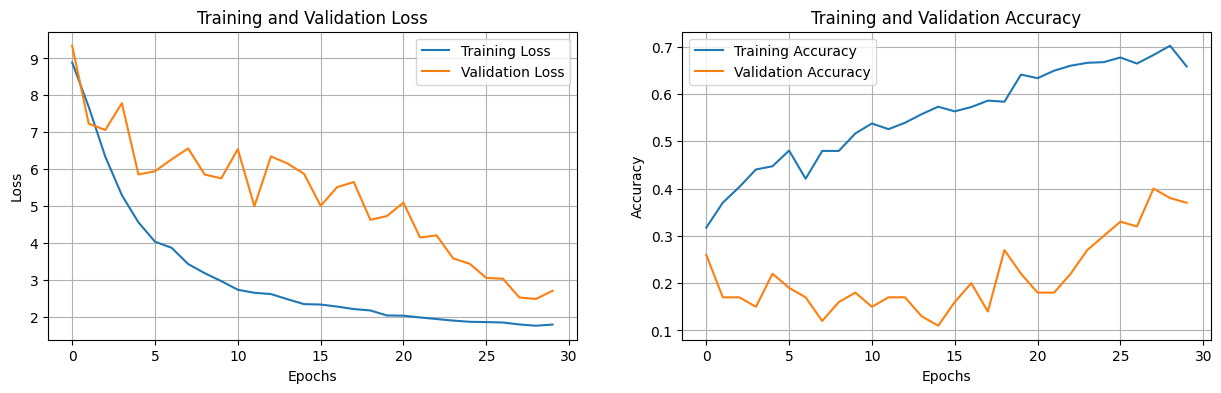

In [12]:
plot_training_history(trained_model_8)

### Best model so far the val loss is dropping the fastest compared to other models 

# Model 7
### High dropout with earlystop

In [98]:
class Model7(GestureRecognitionModel):
    
    def build_model(self):
        model = Sequential()

        # Convolutional Layers
        filters_list = [8, 16, 32, 64]
        model.add(Conv3D(filters_list[0], kernel_size=(3, 3, 3), padding='same', 
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels), kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        for filters in filters_list[1:]:
            model.add(Conv3D(filters, kernel_size=(3, 3, 3), padding='same', kernel_regularizer=l2(0.01)))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Flatten layer
        model.add(Flatten())

        # Fully Connected Layers
        dense_units = [64, 32]
        for units in dense_units:
            model.add(Dense(units, activation='relu', kernel_regularizer=l2(0.01)))
            model.add(BatchNormalization())
            model.add(Dropout(0.7))
            
        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile the model
        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
        return model

In [99]:
frames_to_sample = 25
batch_size = 40
num_epochs = 30
training_sample = 1
image_height = 120
image_width = 120
con3d_model8 = Model7(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height=image_height, image_width = image_width)
model8_1 = con3d_model8.build_model()
print(model8_1.summary())

Model: "sequential_35"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_106 (Conv3D)         (None, 25, 120, 120, 8)   656       

                                                                 

 batch_normalization_163 (B  (None, 25, 120, 120, 8)   32        

 atchNormalization)                                              

                                                                 

 activation_106 (Activation  (None, 25, 120, 120, 8)   0         

 )                                                               

                                                                 

 max_pooling3d_106 (MaxPool  (None, 12, 60, 60, 8)     0         

 ing3D)                                                          

                                                                 

 conv3d_107 (Conv3D)         (None, 12, 60, 60, 16)    3472      

                                     

In [100]:
trained_model_9 = con3d_model8.train_model(model8_1, augmentation=True, patience = 3)

Epoch 1/30

17/17 [==============================] - ETA: 0s - loss: 5.2173 - categorical_accuracy: 0.2496

Epoch 1: val_loss improved from inf to 4.02151, saving model to /kaggle/working/Model_2023-12-0814_51_58.035317/model-00001-4.02151-0.15000.tf

17/17 [==============================] - 164s 10s/step - loss: 5.2173 - categorical_accuracy: 0.2496 - val_loss: 4.0215 - val_categorical_accuracy: 0.1500 - lr: 0.0010

Epoch 2/30

17/17 [==============================] - ETA: 0s - loss: 4.7385 - categorical_accuracy: 0.2881

Epoch 2: val_loss did not improve from 4.02151

17/17 [==============================] - 141s 9s/step - loss: 4.7385 - categorical_accuracy: 0.2881 - val_loss: 4.2034 - val_categorical_accuracy: 0.2600 - lr: 0.0010

Epoch 3/30

17/17 [==============================] - ETA: 0s - loss: 4.4127 - categorical_accuracy: 0.3371

Epoch 3: val_loss did not improve from 4.02151

17/17 [==============================] - 111s 7s/step - loss: 4.4127 - categorical_accuracy: 0.3371

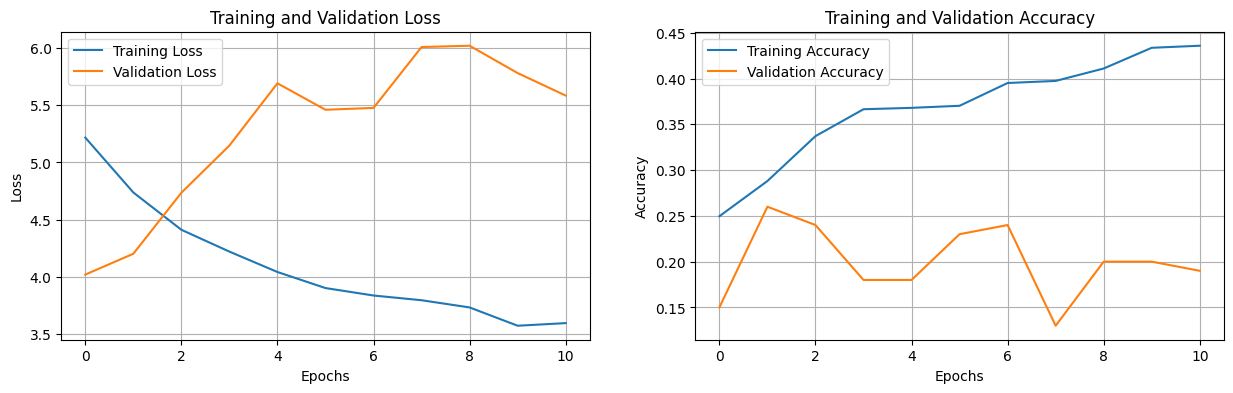

In [116]:
plot_training_history(trained_model_9)

# Model 8
### Adding layers and incresing number of filters in dense layers with low dropout

In [40]:
class Model8(GestureRecognitionModel):
    
    def build_model(self, dropout=0.25):
        model = Sequential()

        # Convolutional Layers
        filters_list = [16, 32, 64, 128]
        
        model.add(Conv3D(filters_list[0], kernel_size=(3, 3, 3), padding='same', 
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        for filters in filters_list[1:]:
            model.add(Conv3D(filters, kernel_size=(3, 3, 3), padding='same'))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Flatten layer
        model.add(Flatten())
        
        # Fully Connected Layers
        dense_units = [256,128]
        for units in dense_units:
            model.add(Dense(units, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dropout(dropout))

        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compiling the model
        optimiser = tf.keras.optimizers.Adam(learning_rate=0.002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model

### Without Augmentation

In [8]:
frames_to_sample = 30
batch_size = 30
num_epochs = 25
training_sample = 1
image_height = 120
image_width = 120
con3d_model6 = Model8(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height=image_height, image_width = image_width)
model6_1 = con3d_model6.build_model()
print(model6_1.summary())

Model: "sequential_2"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_8 (Conv3D)           (None, 30, 120, 120, 16   1312      

                             )                                   

                                                                 

 batch_normalization_12 (Ba  (None, 30, 120, 120, 16   64        

 tchNormalization)           )                                   

                                                                 

 activation_8 (Activation)   (None, 30, 120, 120, 16   0         

                             )                                   

                                                                 

 max_pooling3d_8 (MaxPoolin  (None, 15, 60, 60, 16)    0         

 g3D)                                                            

                                                                 

 conv3d_9 (Conv3D)           (None, 15

In [9]:
trained_model_7 = con3d_model6.train_model(model6_1, augmentation=False, patience = 3, early_stop=False)

Epoch 1/25

23/23 [==============================] - ETA: 0s - loss: 1.6247 - categorical_accuracy: 0.4087

Epoch 1: val_loss improved from inf to 1.95241, saving model to /kaggle/working/Model_2023-12-0907_34_31.010142/model-00001-1.95241-0.23000.tf

23/23 [==============================] - 273s 11s/step - loss: 1.6247 - categorical_accuracy: 0.4087 - val_loss: 1.9524 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04

Epoch 2/25

23/23 [==============================] - ETA: 0s - loss: 0.9085 - categorical_accuracy: 0.6365

Epoch 2: val_loss did not improve from 1.95241

23/23 [==============================] - 100s 5s/step - loss: 0.9085 - categorical_accuracy: 0.6365 - val_loss: 3.2747 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04

Epoch 3/25

23/23 [==============================] - ETA: 0s - loss: 0.7098 - categorical_accuracy: 0.7164

Epoch 3: val_loss did not improve from 1.95241

23/23 [==============================] - 92s 4s/step - loss: 0.7098 - categorical_accuracy:

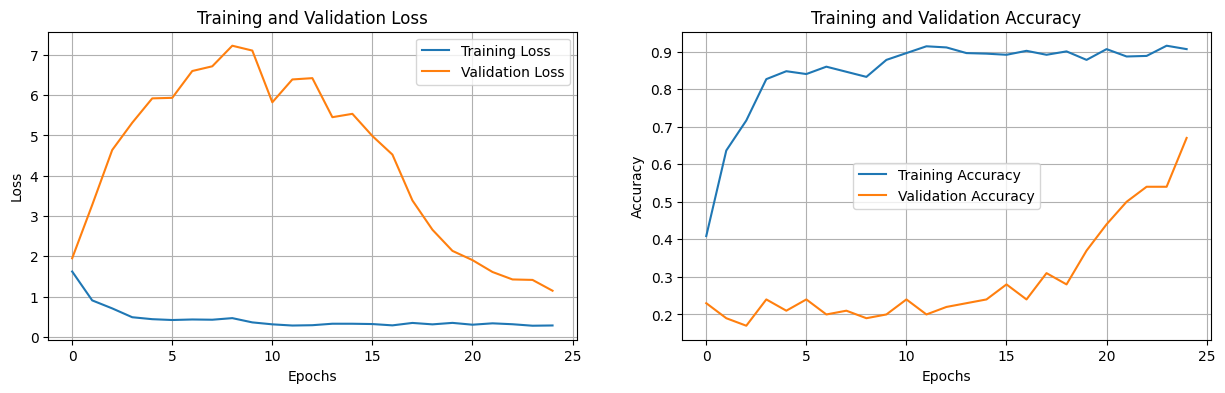

In [10]:
plot_training_history(trained_model_7)

### Reaching good val accuracy but can see overfitting lets try with Augmentation 

In [11]:
frames_to_sample = 30
batch_size = 30
num_epochs = 30
training_sample = 1
image_height = 120
image_width = 120
con3d_model6 = Model8(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height=image_height, image_width = image_width)
model6_2 = con3d_model6.build_model()
print(model6_2.summary())

Model: "sequential_3"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_12 (Conv3D)          (None, 30, 120, 120, 16   1312      

                             )                                   

                                                                 

 batch_normalization_18 (Ba  (None, 30, 120, 120, 16   64        

 tchNormalization)           )                                   

                                                                 

 activation_12 (Activation)  (None, 30, 120, 120, 16   0         

                             )                                   

                                                                 

 max_pooling3d_12 (MaxPooli  (None, 15, 60, 60, 16)    0         

 ng3D)                                                           

                                                                 

 conv3d_13 (Conv3D)          (None, 15

In [12]:
trained_model_100 = con3d_model6.train_model(model6_2, augmentation=True, patience = 3, early_stop=False)

Epoch 1/30

23/23 [==============================] - ETA: 0s - loss: 1.7267 - categorical_accuracy: 0.3884

Epoch 1: val_loss improved from inf to 1.61239, saving model to /kaggle/working/Model_2023-12-0908_20_02.155518/model-00001-1.61239-0.23000.tf

23/23 [==============================] - 147s 6s/step - loss: 1.7267 - categorical_accuracy: 0.3884 - val_loss: 1.6124 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04

Epoch 2/30

23/23 [==============================] - ETA: 0s - loss: 1.2060 - categorical_accuracy: 0.5709

Epoch 2: val_loss did not improve from 1.61239

23/23 [==============================] - 130s 6s/step - loss: 1.2060 - categorical_accuracy: 0.5709 - val_loss: 2.0275 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04

Epoch 3/30

23/23 [==============================] - ETA: 0s - loss: 1.0641 - categorical_accuracy: 0.5920

Epoch 3: val_loss did not improve from 1.61239

23/23 [==============================] - 127s 6s/step - loss: 1.0641 - categorical_accuracy:

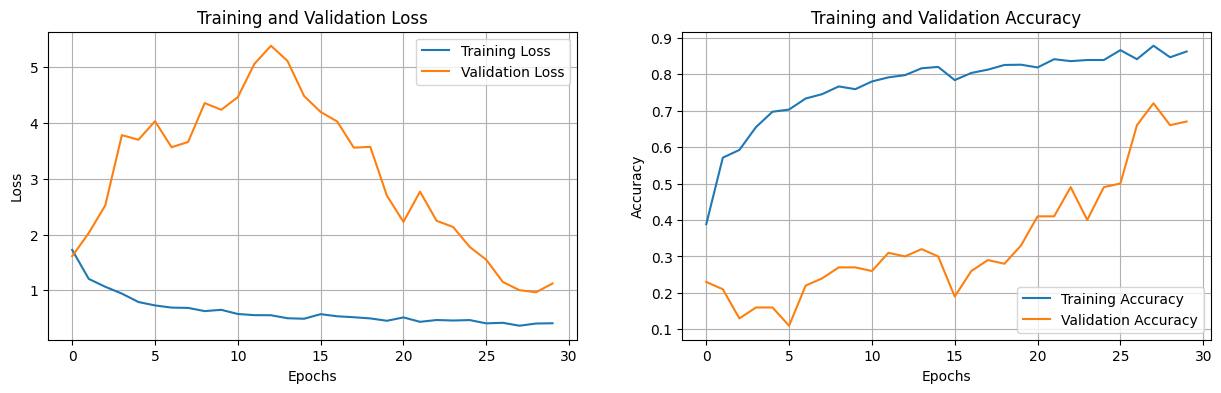

In [13]:
plot_training_history(trained_model_100)

### Can notice fluctuations earlier in val accuracy due to augmentation but lets try with higher dropout

In [37]:
frames_to_sample = 30
batch_size = 30
num_epochs = 30
training_sample = 1
image_height = 120
image_width = 120
con3d_model6 = Model8(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height=image_height, image_width = image_width)
model6_3 = con3d_model6.build_model(dropout=0.8)
print(model6_3.summary())

Model: "sequential_11"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_39 (Conv3D)          (None, 30, 120, 120, 16   1312      

                             )                                   

                                                                 

 batch_normalization_61 (Ba  (None, 30, 120, 120, 16   64        

 tchNormalization)           )                                   

                                                                 

 activation_39 (Activation)  (None, 30, 120, 120, 16   0         

                             )                                   

                                                                 

 max_pooling3d_39 (MaxPooli  (None, 15, 60, 60, 16)    0         

 ng3D)                                                           

                                                                 

 conv3d_40 (Conv3D)          (None, 1

In [38]:
trained_model_105 = con3d_model6.train_model(model6_3, augmentation=True, patience = 3, early_stop=False)

Epoch 1/30

23/23 [==============================] - ETA: 0s - loss: 3.5732 - categorical_accuracy: 0.2097

Epoch 1: val_loss improved from inf to 1.64866, saving model to /kaggle/working/Model_2023-12-0911_03_14.743542/model-00001-1.64866-0.16000.tf

23/23 [==============================] - 149s 6s/step - loss: 3.5732 - categorical_accuracy: 0.2097 - val_loss: 1.6487 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04

Epoch 2/30

23/23 [==============================] - ETA: 0s - loss: 3.3263 - categorical_accuracy: 0.2421

Epoch 2: val_loss did not improve from 1.64866

23/23 [==============================] - 127s 6s/step - loss: 3.3263 - categorical_accuracy: 0.2421 - val_loss: 1.9338 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04

Epoch 3/30

23/23 [==============================] - ETA: 0s - loss: 3.0084 - categorical_accuracy: 0.2843

Epoch 3: val_loss did not improve from 1.64866

23/23 [==============================] - 126s 6s/step - loss: 3.0084 - categorical_accuracy:

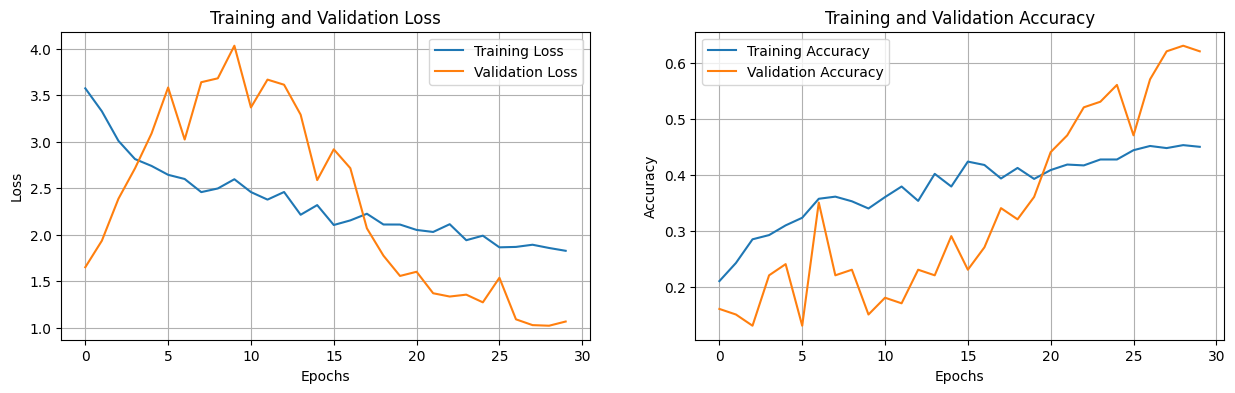

In [39]:
plot_training_history(trained_model_105)

### The model is unable to learn due 0.8 dropout

# Model 9
### Reduced layers and number of filters in dense layer

In [ ]:
class Model9(GestureRecognitionModel):
    
    def build_model(self, dropout=0.25):
        model = Sequential()

        # Convolutional Layers
        filters_list = [16, 32, 64]
        
        model.add(Conv3D(filters_list[0], kernel_size=(3, 3, 3), padding='same', 
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        for filters in filters_list[1:]:
            model.add(Conv3D(filters, kernel_size=(3, 3, 3), padding='same'))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Flatten layer
        model.add(Flatten())
        
        # Fully Connected Layers
        dense_units = [32,16]
        for units in dense_units:
            model.add(Dense(units, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dropout(dropout))

        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compiling the model
        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model

In [23]:
frames_to_sample = 30
batch_size = 30
num_epochs = 30
training_sample = 1
image_height = 120
image_width = 120
con3d_model9 = Model9(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height=image_height, image_width = image_width)
model9_1 = con3d_model9.build_model(dropout=0.8)
print(model9_1.summary())

Model: "sequential_7"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_25 (Conv3D)          (None, 30, 120, 120, 16   1312      

                             )                                   

                                                                 

 batch_normalization_39 (Ba  (None, 30, 120, 120, 16   64        

 tchNormalization)           )                                   

                                                                 

 activation_25 (Activation)  (None, 30, 120, 120, 16   0         

                             )                                   

                                                                 

 max_pooling3d_25 (MaxPooli  (None, 15, 60, 60, 16)    0         

 ng3D)                                                           

                                                                 

 conv3d_26 (Conv3D)          (None, 15

In [24]:
trained_model_101 = con3d_model9.train_model(model9_1, augmentation=True, patience = 3)

Epoch 1/30

23/23 [==============================] - ETA: 0s - loss: 2.7979 - categorical_accuracy: 0.2157

Epoch 1: val_loss improved from inf to 1.62316, saving model to /kaggle/working/Model_2023-12-0909_35_58.246988/model-00001-1.62316-0.21000.tf

23/23 [==============================] - 163s 7s/step - loss: 2.7979 - categorical_accuracy: 0.2157 - val_loss: 1.6232 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04

Epoch 2/30

23/23 [==============================] - ETA: 0s - loss: 2.5457 - categorical_accuracy: 0.2360

Epoch 2: val_loss improved from 1.62316 to 1.61919, saving model to /kaggle/working/Model_2023-12-0909_35_58.246988/model-00002-1.61919-0.19000.tf

23/23 [==============================] - 130s 6s/step - loss: 2.5457 - categorical_accuracy: 0.2360 - val_loss: 1.6192 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04

Epoch 3/30

23/23 [==============================] - ETA: 0s - loss: 2.4770 - categorical_accuracy: 0.2436

Epoch 3: val_loss did not improve from 1

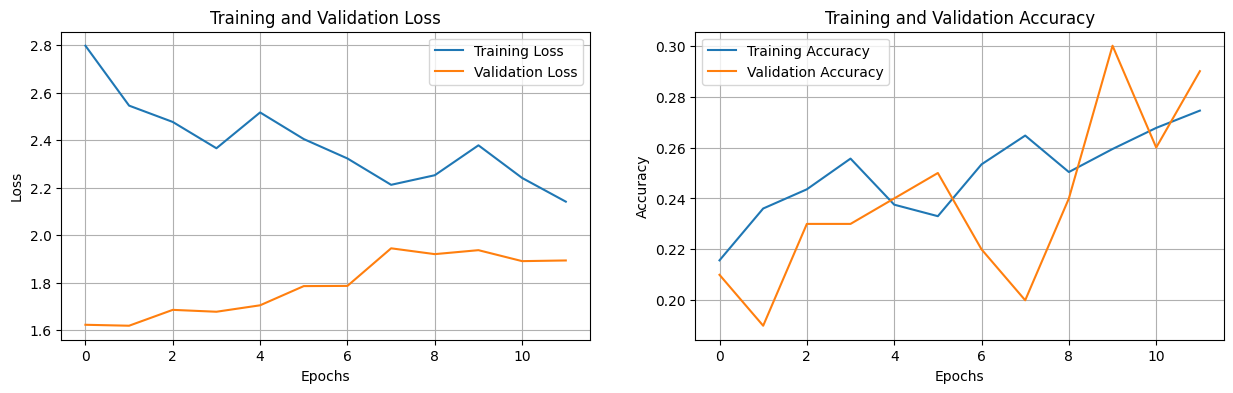

In [25]:
plot_training_history(trained_model_101)

### same issue as the previous model, lets decrease the dropout rate

In [27]:
frames_to_sample = 30
batch_size = 30
num_epochs = 30
training_sample = 1
image_height = 120
image_width = 120
con3d_model9 = Model9(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height=image_height, image_width = image_width)
model9_2 = con3d_model9.build_model(dropout=0.6)
print(model9_2.summary())

Model: "sequential_8"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_28 (Conv3D)          (None, 30, 120, 120, 16   1312      

                             )                                   

                                                                 

 batch_normalization_44 (Ba  (None, 30, 120, 120, 16   64        

 tchNormalization)           )                                   

                                                                 

 activation_28 (Activation)  (None, 30, 120, 120, 16   0         

                             )                                   

                                                                 

 max_pooling3d_28 (MaxPooli  (None, 15, 60, 60, 16)    0         

 ng3D)                                                           

                                                                 

 conv3d_29 (Conv3D)          (None, 15

In [31]:
trained_model_102 = con3d_model9.train_model(model9_2, augmentation=True, patience = 3)

Epoch 1/30

23/23 [==============================] - ETA: 0s - loss: 2.1903 - categorical_accuracy: 0.2647

Epoch 1: val_loss improved from inf to 1.65205, saving model to /kaggle/working/Model_2023-12-0910_06_01.832917/model-00001-1.65205-0.22000.tf

23/23 [==============================] - 145s 6s/step - loss: 2.1903 - categorical_accuracy: 0.2647 - val_loss: 1.6520 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04

Epoch 2/30

23/23 [==============================] - ETA: 0s - loss: 1.9547 - categorical_accuracy: 0.2994

Epoch 2: val_loss did not improve from 1.65205

23/23 [==============================] - 129s 6s/step - loss: 1.9547 - categorical_accuracy: 0.2994 - val_loss: 1.7487 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04

Epoch 3/30

23/23 [==============================] - ETA: 0s - loss: 1.8072 - categorical_accuracy: 0.3401

Epoch 3: val_loss did not improve from 1.65205

23/23 [==============================] - 126s 6s/step - loss: 1.8072 - categorical_accuracy:

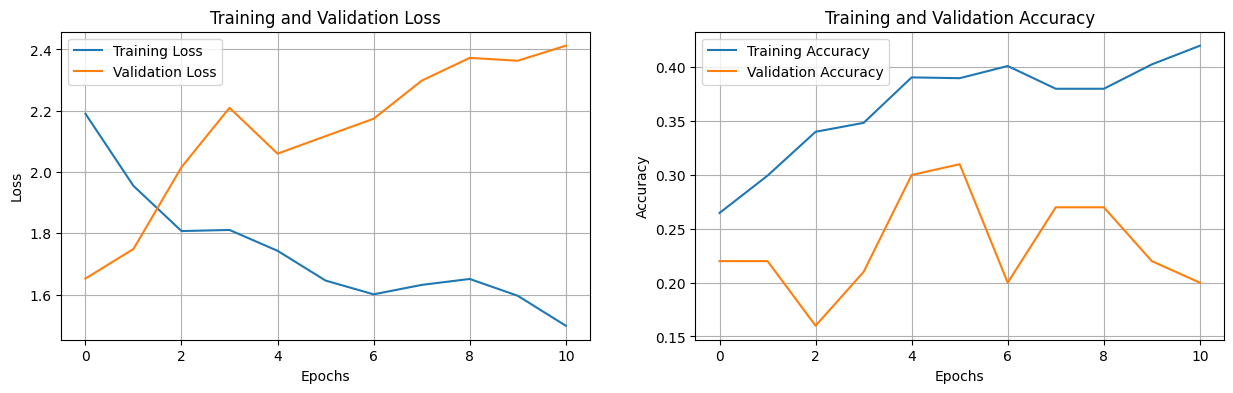

In [32]:
plot_training_history(trained_model_102)

# Model 10
### Same as model 8 but will run it for higher number of epoch

In [49]:
class Model10(GestureRecognitionModel):
    
    def build_model(self, dropout=0.25):
        model = Sequential()

        # Convolutional Layers
        filters_list = [16, 32, 64, 128]
        
        model.add(Conv3D(filters_list[0], kernel_size=(3, 3, 3), padding='same', 
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels), kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        for filters in filters_list[1:]:
            model.add(Conv3D(filters, kernel_size=(3, 3, 3), padding='same', kernel_regularizer=l2(0.01)))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Flatten layer
        model.add(Flatten())
        
        # Fully Connected Layers
        dense_units = [256,128]  # Reduced number of units
        for units in dense_units:
            model.add(Dense(units, activation='relu', kernel_regularizer=l2(0.01)))
            model.add(BatchNormalization())
            model.add(Dropout(dropout))

        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compiling the model
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model

In [50]:
frames_to_sample = 30
batch_size = 30
num_epochs = 50
training_sample = 1
image_height = 120
image_width = 120
con3d_model10 = Model10(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height=image_height, image_width = image_width)
model10_1 = con3d_model10.build_model()
print(model10_1.summary())

Model: "sequential_14"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_51 (Conv3D)          (None, 30, 120, 120, 16   1312      

                             )                                   

                                                                 

 batch_normalization_79 (Ba  (None, 30, 120, 120, 16   64        

 tchNormalization)           )                                   

                                                                 

 activation_51 (Activation)  (None, 30, 120, 120, 16   0         

                             )                                   

                                                                 

 max_pooling3d_51 (MaxPooli  (None, 15, 60, 60, 16)    0         

 ng3D)                                                           

                                                                 

 conv3d_52 (Conv3D)          (None, 1

In [51]:
trained_model_106 = con3d_model10.train_model(model10_1, augmentation=True, patience = 3)

Epoch 1/50

23/23 [==============================] - ETA: 0s - loss: 9.4521 - categorical_accuracy: 0.4472

Epoch 1: val_loss improved from inf to 10.55104, saving model to /kaggle/working/Model_2023-12-0912_18_33.576966/model-00001-10.55104-0.26000.tf

23/23 [==============================] - 205s 9s/step - loss: 9.4521 - categorical_accuracy: 0.4472 - val_loss: 10.5510 - val_categorical_accuracy: 0.2600 - lr: 0.0010

Epoch 2/50

23/23 [==============================] - ETA: 0s - loss: 8.1059 - categorical_accuracy: 0.5852

Epoch 2: val_loss improved from 10.55104 to 8.99787, saving model to /kaggle/working/Model_2023-12-0912_18_33.576966/model-00002-8.99787-0.18000.tf

23/23 [==============================] - 147s 7s/step - loss: 8.1059 - categorical_accuracy: 0.5852 - val_loss: 8.9979 - val_categorical_accuracy: 0.1800 - lr: 0.0010

Epoch 3/50

23/23 [==============================] - ETA: 0s - loss: 7.0585 - categorical_accuracy: 0.6184

Epoch 3: val_loss improved from 8.99787 to 8

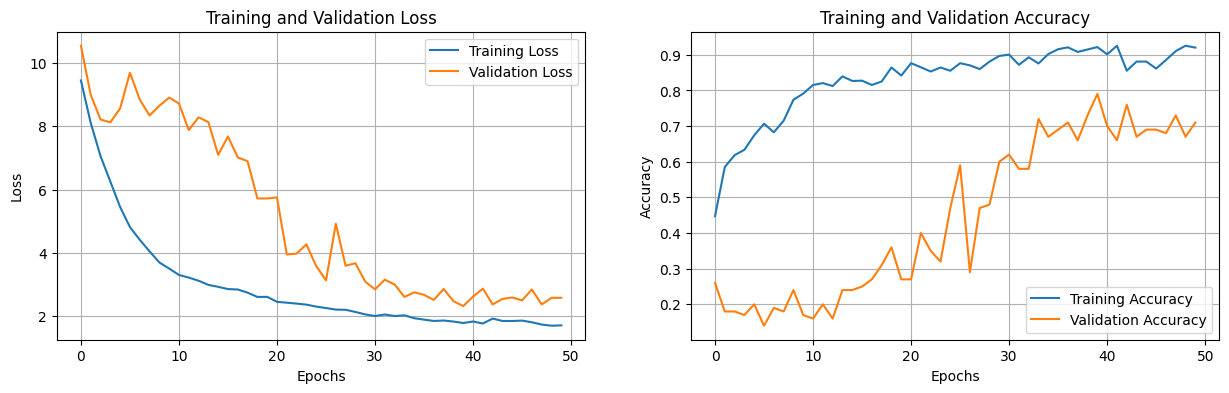

In [52]:
plot_training_history(trained_model_106)

## Best Result so far reaching 79% accuracy in epoch 40

# Model 11
### Reducing number of dense layer neurons/units to simplify the model a bit

In [9]:
class Model11(GestureRecognitionModel):
    
    def build_model(self, dropout=0.25, dense_units = [128,64]):
        model = Sequential()

        # Convolutional Layers
        filters_list = [16, 32, 64, 128]

        for filters in filters_list:
            model.add(Conv3D(filters, kernel_size=(3, 3, 3), padding='same',
                             input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels) kernel_regularizer=l2(0.01)))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Flatten layer
        model.add(Flatten())
        
        # Fully Connected Layers 
        for units in dense_units:
            model.add(Dense(units, activation='relu', kernel_regularizer=l2(0.01)))
            model.add(BatchNormalization())
            model.add(Dropout(dropout))

        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compiling the model
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model

In [13]:
frames_to_sample = 30
batch_size = 30
num_epochs = 45
training_sample = 1
image_height = 120
image_width = 120
con3d_model11 = Model11(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height=image_height, image_width = image_width)
model11_1 = con3d_model11.build_model()
print(model11_1.summary())

Model: "sequential_4"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_15 (Conv3D)          (None, 30, 120, 120, 16   1312      

                             )                                   

                                                                 

 batch_normalization_23 (Ba  (None, 30, 120, 120, 16   64        

 tchNormalization)           )                                   

                                                                 

 activation_15 (Activation)  (None, 30, 120, 120, 16   0         

                             )                                   

                                                                 

 max_pooling3d_15 (MaxPooli  (None, 15, 60, 60, 16)    0         

 ng3D)                                                           

                                                                 

 conv3d_16 (Conv3D)          (None, 15

In [14]:
trained_model_107 = con3d_model11.train_model(model11_1, augmentation=True, patience = 3)

Epoch 1/45

23/23 [==============================] - ETA: 0s - loss: 6.3703 - categorical_accuracy: 0.4555

Epoch 1: val_loss improved from inf to 7.37878, saving model to /kaggle/working/Model_2023-12-1109_28_12.698916/model-00001-7.37878-0.22000.tf

23/23 [==============================] - 205s 8s/step - loss: 6.3703 - categorical_accuracy: 0.4555 - val_loss: 7.3788 - val_categorical_accuracy: 0.2200 - lr: 0.0010

Epoch 2/45

23/23 [==============================] - ETA: 0s - loss: 5.5944 - categorical_accuracy: 0.5588

Epoch 2: val_loss improved from 7.37878 to 6.64880, saving model to /kaggle/working/Model_2023-12-1109_28_12.698916/model-00002-6.64880-0.17000.tf

23/23 [==============================] - 119s 5s/step - loss: 5.5944 - categorical_accuracy: 0.5588 - val_loss: 6.6488 - val_categorical_accuracy: 0.1700 - lr: 0.0010

Epoch 3/45

23/23 [==============================] - ETA: 0s - loss: 4.9210 - categorical_accuracy: 0.6448

Epoch 3: val_loss improved from 6.64880 to 6.212

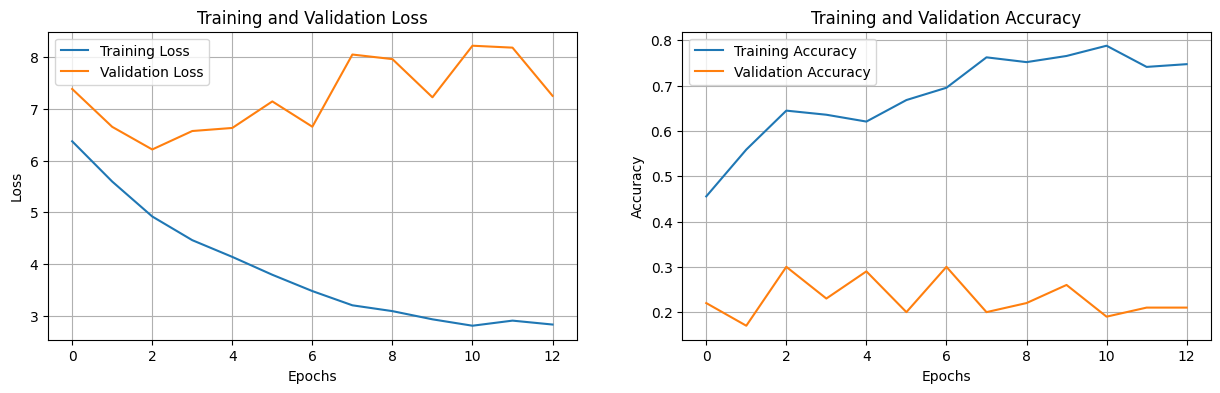

In [15]:
plot_training_history(trained_model_107)

### Increasing dropout and decreasing dense units

In [17]:
frames_to_sample = 30
batch_size = 30
num_epochs = 45
training_sample = 1
image_height = 120
image_width = 120
con3d_model11 = Model11(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height=image_height, image_width = image_width)
model11_2 = con3d_model11.build_model(dropout=0.4, dense_units=[64,32])
print(model11_2.summary())

Model: "sequential_5"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_19 (Conv3D)          (None, 30, 120, 120, 16   1312      

                             )                                   

                                                                 

 batch_normalization_29 (Ba  (None, 30, 120, 120, 16   64        

 tchNormalization)           )                                   

                                                                 

 activation_19 (Activation)  (None, 30, 120, 120, 16   0         

                             )                                   

                                                                 

 max_pooling3d_19 (MaxPooli  (None, 15, 60, 60, 16)    0         

 ng3D)                                                           

                                                                 

 conv3d_20 (Conv3D)          (None, 15

In [18]:
trained_model_108 = con3d_model11.train_model(model11_2, augmentation=True, patience = 3)

Epoch 1/45

23/23 [==============================] - ETA: 0s - loss: 5.0085 - categorical_accuracy: 0.3228

Epoch 1: val_loss improved from inf to 4.95758, saving model to /kaggle/working/Model_2023-12-1110_07_27.542024/model-00001-4.95758-0.22000.tf

23/23 [==============================] - 136s 6s/step - loss: 5.0085 - categorical_accuracy: 0.3228 - val_loss: 4.9576 - val_categorical_accuracy: 0.2200 - lr: 0.0010

Epoch 2/45

23/23 [==============================] - ETA: 0s - loss: 4.4259 - categorical_accuracy: 0.4502

Epoch 2: val_loss did not improve from 4.95758

23/23 [==============================] - 112s 5s/step - loss: 4.4259 - categorical_accuracy: 0.4502 - val_loss: 6.4726 - val_categorical_accuracy: 0.2400 - lr: 0.0010

Epoch 3/45

23/23 [==============================] - ETA: 0s - loss: 4.1135 - categorical_accuracy: 0.5136

Epoch 3: val_loss did not improve from 4.95758

23/23 [==============================] - 135s 6s/step - loss: 4.1135 - categorical_accuracy: 0.5136 

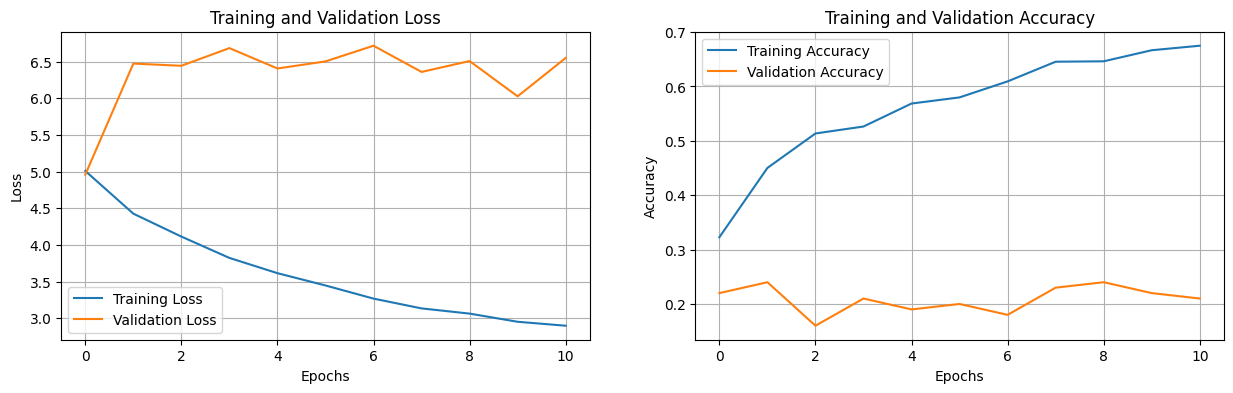

In [19]:
plot_training_history(trained_model_108)

# RNN + CNN Model 1

In [50]:
class RNN_CNN_LTSM(GestureRecognitionModel):
    
    def build_model(self, ltsm_cells=64, dense_neurons=[64], dropout=0.25, learning_rate = 0.0010):

        model = Sequential()

        # Convolutional Layers
        filters_list = [16, 32, 64, 128]

        for filters in filters_list:
            model.add(TimeDistributed(Conv2D(filters, (3, 3), padding='same', activation='relu'),
                                      input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
            model.add(TimeDistributed(BatchNormalization()))
            model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        # Recurrent Layer
        model.add(LSTM(ltsm_cells))
        model.add(Dropout(dropout))

        # Fully Connected Layers
        for units in dense_neurons:
            model.add(Dense(units, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dropout(dropout))

        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compiling the model
        optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [43]:
frames_to_sample = 30
batch_size = 30
num_epochs = 30
training_sample = 1
image_height = 120
image_width = 120
lstm_model1 = RNN_CNN_LTSM(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height = image_height, image_width = image_width)
cnn_rnn_model1 = lstm_model1.build_model(dropout=0.5)
print(cnn_rnn_model1.summary())

Model: "sequential_9"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 time_distributed_54 (TimeD  (None, 30, 120, 120, 16   448       

 istributed)                 )                                   

                                                                 

 time_distributed_55 (TimeD  (None, 30, 120, 120, 16   64        

 istributed)                 )                                   

                                                                 

 time_distributed_56 (TimeD  (None, 30, 60, 60, 16)    0         

 istributed)                                                     

                                                                 

 time_distributed_57 (TimeD  (None, 30, 60, 60, 32)    4640      

 istributed)                                                     

                                                                 

 time_distributed_58 (TimeD  (None, 30

In [44]:
trained_model_110 = lstm_model1.train_model(cnn_rnn_model1, patience = 3, early_stop=False)

Epoch 1/30

22/23 [===========================>..] - ETA: 3s - loss: 2.4174 - categorical_accuracy: 0.2152

Epoch 1: val_loss improved from inf to 1.71103, saving model to /kaggle/working/Model_2023-12-1112_43_47.067559/model-00001-1.71103-0.21000.tf

23/23 [==============================] - 106s 5s/step - loss: 2.4159 - categorical_accuracy: 0.2157 - val_loss: 1.7110 - val_categorical_accuracy: 0.2100 - lr: 0.0010

Epoch 2/30

22/23 [===========================>..] - ETA: 3s - loss: 2.1819 - categorical_accuracy: 0.2712

Epoch 2: val_loss did not improve from 1.71103

23/23 [==============================] - 87s 4s/step - loss: 2.1842 - categorical_accuracy: 0.2700 - val_loss: 1.7329 - val_categorical_accuracy: 0.1900 - lr: 0.0010

Epoch 3/30

22/23 [===========================>..] - ETA: 2s - loss: 2.0196 - categorical_accuracy: 0.2924

Epoch 3: val_loss did not improve from 1.71103

23/23 [==============================] - 81s 4s/step - loss: 2.0175 - categorical_accuracy: 0.2926 - 

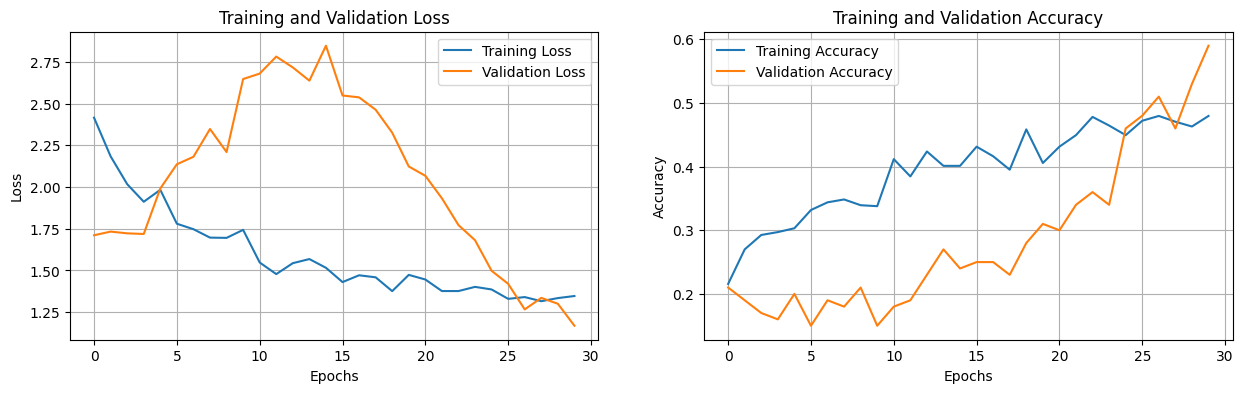

In [45]:
plot_training_history(trained_model_110)

### Increasing dropout and number of epochs

In [53]:
frames_to_sample = 20
batch_size = 30
num_epochs = 40
training_sample = 1
image_height = 120
image_width = 120
lstm_model1 = RNN_CNN_LTSM(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height = image_height, image_width = image_width)
cnn_rnn_model2 = lstm_model1.build_model(dropout=0.45,learning_rate = 0.0002)
print(cnn_rnn_model2.summary())

Model: "sequential_12"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 time_distributed_93 (TimeD  (None, 20, 120, 120, 16   448       

 istributed)                 )                                   

                                                                 

 time_distributed_94 (TimeD  (None, 20, 120, 120, 16   64        

 istributed)                 )                                   

                                                                 

 time_distributed_95 (TimeD  (None, 20, 60, 60, 16)    0         

 istributed)                                                     

                                                                 

 time_distributed_96 (TimeD  (None, 20, 60, 60, 32)    4640      

 istributed)                                                     

                                                                 

 time_distributed_97 (TimeD  (None, 2

In [67]:
trained_model_111 = lstm_model1.train_model(cnn_rnn_model2, augmentation=True, patience = 3, early_stop=False)

Epoch 1/40

23/23 [==============================] - ETA: 0s - loss: 2.3188 - categorical_accuracy: 0.2413

Epoch 1: val_loss improved from inf to 1.59598, saving model to /kaggle/working/Model_2023-12-1114_00_51.027637/model-00001-1.59598-0.24000.tf

23/23 [==============================] - 156s 7s/step - loss: 2.3188 - categorical_accuracy: 0.2413 - val_loss: 1.5960 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04

Epoch 2/40

23/23 [==============================] - ETA: 0s - loss: 2.0191 - categorical_accuracy: 0.2813

Epoch 2: val_loss did not improve from 1.59598

23/23 [==============================] - 145s 7s/step - loss: 2.0191 - categorical_accuracy: 0.2813 - val_loss: 1.6373 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04

Epoch 3/40

23/23 [==============================] - ETA: 0s - loss: 1.8841 - categorical_accuracy: 0.3296

Epoch 3: val_loss improved from 1.59598 to 1.58967, saving model to /kaggle/working/Model_2023-12-1114_00_51.027637/model-00003-1.58967-0.30

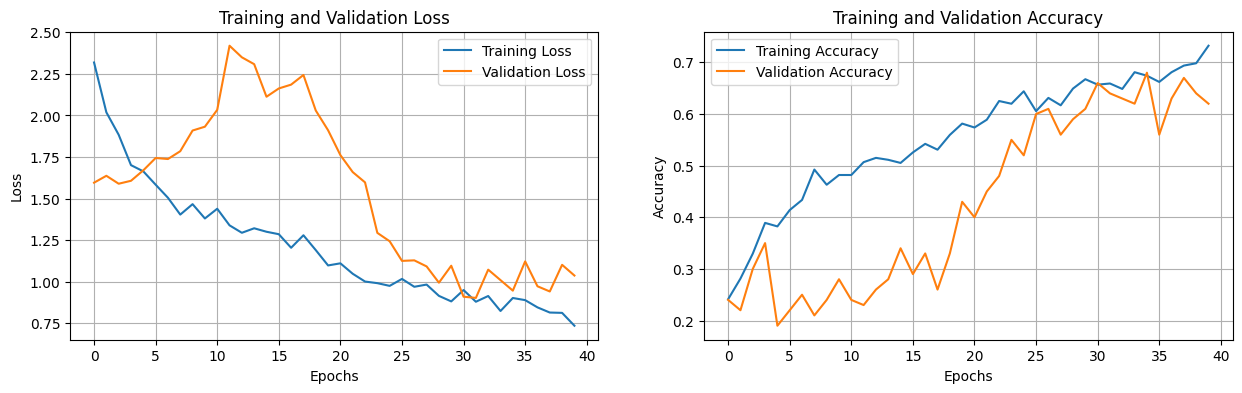

In [ ]:
plot_training_history(trained_model_111)

### Better results lets reduce the dropout even more

In [69]:
frames_to_sample = 30
batch_size = 30
num_epochs = 40
training_sample = 1
image_height = 120
image_width = 120
lstm_model1 = RNN_CNN_LTSM(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height = image_height, image_width = image_width)
cnn_rnn_model3 = lstm_model1.build_model(dropout=0.35,learning_rate = 0.0002)
print(cnn_rnn_model3.summary())

Model: "sequential_15"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 time_distributed_132 (Time  (None, 30, 120, 120, 16   448       

 Distributed)                )                                   

                                                                 

 time_distributed_133 (Time  (None, 30, 120, 120, 16   64        

 Distributed)                )                                   

                                                                 

 time_distributed_134 (Time  (None, 30, 60, 60, 16)    0         

 Distributed)                                                    

                                                                 

 time_distributed_135 (Time  (None, 30, 60, 60, 32)    4640      

 Distributed)                                                    

                                                                 

 time_distributed_136 (Time  (None, 3

In [70]:
trained_model_112 = lstm_model1.train_model(cnn_rnn_model3, augmentation=True, patience = 5, early_stop=False)

Epoch 1/40

23/23 [==============================] - ETA: 0s - loss: 2.0928 - categorical_accuracy: 0.2481

Epoch 1: val_loss improved from inf to 1.64110, saving model to /kaggle/working/Model_2023-12-1115_19_12.215643/model-00001-1.64110-0.22000.tf

23/23 [==============================] - 138s 6s/step - loss: 2.0928 - categorical_accuracy: 0.2481 - val_loss: 1.6411 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04

Epoch 2/40

23/23 [==============================] - ETA: 0s - loss: 1.7928 - categorical_accuracy: 0.3341

Epoch 2: val_loss did not improve from 1.64110

23/23 [==============================] - 115s 5s/step - loss: 1.7928 - categorical_accuracy: 0.3341 - val_loss: 1.7778 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04

Epoch 3/40

23/23 [==============================] - ETA: 0s - loss: 1.6696 - categorical_accuracy: 0.3703

Epoch 3: val_loss did not improve from 1.64110

23/23 [==============================] - 114s 5s/step - loss: 1.6696 - categorical_accuracy:

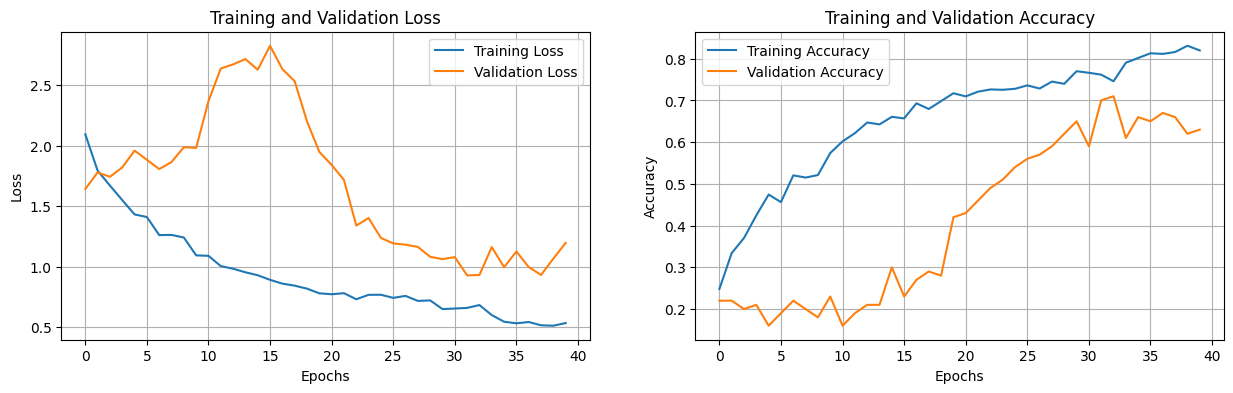

In [71]:
plot_training_history(trained_model_112)

# RNN + CNN Model 2

In [74]:
class RNN_CNN_GRU(GestureRecognitionModel):
    
    def build_model(self, gru_cells=64, dense_neurons=[64], dropout=0.25, learning_rate = 0.0010):

        model = Sequential()

        # Convolutional Layers
        filters_list = [16, 32, 64, 128]

        for filters in filters_list:
            model.add(TimeDistributed(Conv2D(filters, (3, 3), padding='same', activation='relu'),
                                      input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
            model.add(TimeDistributed(BatchNormalization()))
            model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        # Recurrent Layer
        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))

        # Fully Connected Layers
        for units in dense_neurons:
            model.add(Dense(units, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dropout(dropout))

        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compiling the model
        optimiser = tf.keras.optimizers.Adam(learning_rate)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [75]:
frames_to_sample = 30
batch_size = 30
num_epochs = 40
training_sample = 1
image_height = 120
image_width = 120
gru_model1 = RNN_CNN_GRU(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height = image_height, image_width = image_width)
cnn_rnn_model4 = gru_model1.build_model(dropout=0.30,learning_rate = 0.0006)
print(cnn_rnn_model4.summary())

Model: "sequential_17"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 time_distributed_158 (Time  (None, 30, 120, 120, 16   448       

 Distributed)                )                                   

                                                                 

 time_distributed_159 (Time  (None, 30, 120, 120, 16   64        

 Distributed)                )                                   

                                                                 

 time_distributed_160 (Time  (None, 30, 60, 60, 16)    0         

 Distributed)                                                    

                                                                 

 time_distributed_161 (Time  (None, 30, 60, 60, 32)    4640      

 Distributed)                                                    

                                                                 

 time_distributed_162 (Time  (None, 3

In [76]:
trained_model_113 = gru_model1.train_model(cnn_rnn_model4, augmentation=True, patience = 5, early_stop=False)

Epoch 1/40

23/23 [==============================] - ETA: 0s - loss: 1.9581 - categorical_accuracy: 0.3100

Epoch 1: val_loss improved from inf to 1.63249, saving model to /kaggle/working/Model_2023-12-1116_50_10.431892/model-00001-1.63249-0.28000.tf

23/23 [==============================] - 143s 6s/step - loss: 1.9581 - categorical_accuracy: 0.3100 - val_loss: 1.6325 - val_categorical_accuracy: 0.2800 - lr: 6.0000e-04

Epoch 2/40

23/23 [==============================] - ETA: 0s - loss: 1.6841 - categorical_accuracy: 0.3793

Epoch 2: val_loss improved from 1.63249 to 1.56841, saving model to /kaggle/working/Model_2023-12-1116_50_10.431892/model-00002-1.56841-0.36000.tf

23/23 [==============================] - 184s 8s/step - loss: 1.6841 - categorical_accuracy: 0.3793 - val_loss: 1.5684 - val_categorical_accuracy: 0.3600 - lr: 6.0000e-04

Epoch 3/40

23/23 [==============================] - ETA: 0s - loss: 1.5439 - categorical_accuracy: 0.4148

Epoch 3: val_loss did not improve from 1

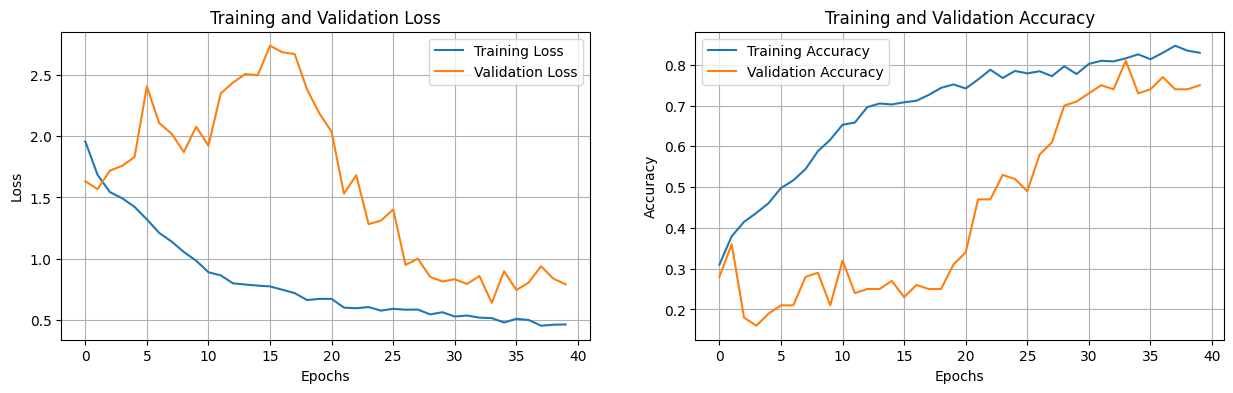

In [77]:
plot_training_history(trained_model_113)

## Best Results so far with 81% val accuracy

In [8]:
frames_to_sample = 30
batch_size = 30
num_epochs = 40
training_sample = 1
image_height = 120
image_width = 120
lstm_model1 = RNN_CNN_LSTM(frames_to_sample = frames_to_sample, batch_size = batch_size, percent_of_training_sample = training_sample,
                       num_epochs = num_epochs, image_height = image_height, image_width = image_width)
cnn_rnn_model5 = lstm_model1.build_model(dropout=0.30,learning_rate = 0.0006)
print(cnn_rnn_model5.summary())

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 time_distributed (TimeDist  (None, 30, 120, 120, 16   448       

 ributed)                    )                                   

                                                                 

 time_distributed_1 (TimeDi  (None, 30, 120, 120, 16   64        

 stributed)                  )                                   

                                                                 

 time_distributed_2 (TimeDi  (None, 30, 60, 60, 16)    0         

 stributed)                                                      

                                                                 

 time_distributed_3 (TimeDi  (None, 30, 60, 60, 32)    4640      

 stributed)                                                      

                                                                 

 time_distributed_4 (TimeDi  (None, 30, 

In [9]:
trained_model_114 = lstm_model1.train_model(cnn_rnn_model5, augmentation=True, patience = 5, early_stop=False)

Epoch 1/40

23/23 [==============================] - ETA: 0s - loss: 1.9828 - categorical_accuracy: 0.2926

Epoch 1: val_loss improved from inf to 1.61888, saving model to /kaggle/working/Model_2023-12-1204_59_32.432154/model-00001-1.61888-0.25000.tf

23/23 [==============================] - 200s 8s/step - loss: 1.9828 - categorical_accuracy: 0.2926 - val_loss: 1.6189 - val_categorical_accuracy: 0.2500 - lr: 6.0000e-04

Epoch 2/40

23/23 [==============================] - ETA: 0s - loss: 1.7290 - categorical_accuracy: 0.3620

Epoch 2: val_loss did not improve from 1.61888

23/23 [==============================] - 117s 5s/step - loss: 1.7290 - categorical_accuracy: 0.3620 - val_loss: 1.6972 - val_categorical_accuracy: 0.2400 - lr: 6.0000e-04

Epoch 3/40

23/23 [==============================] - ETA: 0s - loss: 1.5566 - categorical_accuracy: 0.4186

Epoch 3: val_loss did not improve from 1.61888

23/23 [==============================] - 120s 5s/step - loss: 1.5566 - categorical_accuracy:

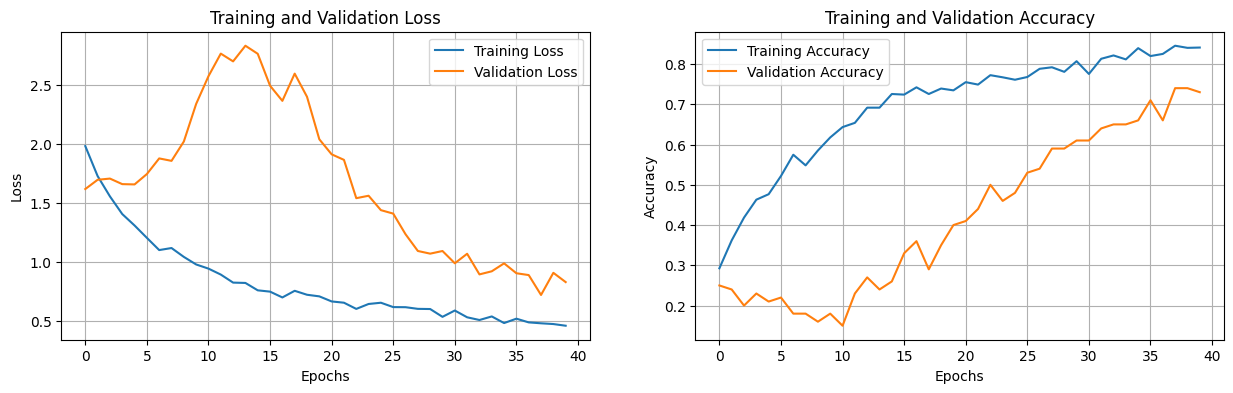

In [10]:
plot_training_history(trained_model_114)

# Conclusion 
## Top Models : 
### Model 10 using Conv3D  Validation loss = 2.31314 Validation accuracy = 79% size = 7.38 MB Total params = 1933765
### RNN + CNN Model 2 using GRU Validation loss = 0.63840 Validation accuracy = 81% size = 5.04 MB Total params = 1320037

In [12]:
import tensorflow as tf

model = tf.keras.models.load_model('/kaggle/input/gesture-recognition-model/model-00034-0.63840-0.81000.tf')

In [20]:
batch_size = 30
gru_model1 = RNN_CNN_GRU(batch_size = batch_size, image_height = 120, image_width=120)
gen = gru_model1.custom_generator(gru_model1.val_path, gru_model1.val_doc, batch_size)

In [25]:
batch_data, batch_labels=next(gen)

predictions = np.argmax(model.predict(batch_data[:,:,:,:,:]), axis=1)

class_labels = {0: 'Left_Swipe', 1: 'Right_Swipe', 2: 'Stop', 3: 'Thumbs_Down', 4: 'Thumbs_Up'}
predicted_labels = [class_labels[index] for index in predictions]

ground_truth_labels = [class_labels[index] for index in np.argmax(batch_labels, axis=1)]
accuracy = np.mean(np.array(ground_truth_labels) == np.array(predicted_labels))

df = pd.DataFrame({'Ground Truth': ground_truth_labels, 'Predicted Value': predicted_labels})

print(df)
print(f'Accuracy: {accuracy * 100:.2f}%')

1/1 [==============================] - 3s 3s/step

   Ground Truth Predicted Value

0     Thumbs_Up       Thumbs_Up

1    Left_Swipe      Left_Swipe

2     Thumbs_Up       Thumbs_Up

3    Left_Swipe      Left_Swipe

4     Thumbs_Up       Thumbs_Up

5   Thumbs_Down     Thumbs_Down

6     Thumbs_Up       Thumbs_Up

7          Stop     Right_Swipe

8   Right_Swipe            Stop

9    Left_Swipe      Left_Swipe

10  Right_Swipe     Right_Swipe

11  Thumbs_Down     Thumbs_Down

12  Right_Swipe     Right_Swipe

13         Stop            Stop

14         Stop            Stop

15  Thumbs_Down     Thumbs_Down

16  Thumbs_Down     Thumbs_Down

17  Right_Swipe     Right_Swipe

18  Right_Swipe     Right_Swipe

19  Right_Swipe     Right_Swipe

20  Thumbs_Down     Thumbs_Down

21    Thumbs_Up       Thumbs_Up

22    Thumbs_Up       Thumbs_Up

23         Stop            Stop

24         Stop            Stop

25   Left_Swipe      Left_Swipe

26   Left_Swipe      Left_Swipe

27         Stop      Left